# Inteligent systems seminar 1

## Tree implementation

In [1]:
from abc import ABC, abstractmethod # abstract classes
import numpy as np # for fitness function
import random

# treat warnings as errors
import warnings
warnings.filterwarnings("error")


# base class
class Node(ABC):
    INT_ARRAY_SIZE = 1000
    P_GENERATION_X = 0.1
    P_ENDTREE_INIT = 0.3
    LONG_EQUATION_PENALTY = 0.0001
    ENABLE_EXTRA_OPERATORS = True

    @abstractmethod
    def evaluate(self, x):
        pass

    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def number_of_nodes(self):
        pass
    
    @abstractmethod
    def list_of_nodes(self):
        pass


# implementations of Node
class BinaryOperator(Node):
    def __init__(self, operator, left_child, right_child):
        self.parent = None
        self.operator = operator
        self.right_child = right_child
        self.left_child = left_child
        left_child.parent = self
        right_child.parent = self

    def evaluate(self, x):
        match(self.operator):
            case '+':
                return self.left_child.evaluate(x) + self.right_child.evaluate(x)
            case '-':
                return self.left_child.evaluate(x) - self.right_child.evaluate(x)
            case '*':
                return self.left_child.evaluate(x) * self.right_child.evaluate(x)
            case '/':
                return self.left_child.evaluate(x) / self.right_child.evaluate(x)
            case '^':
                return self.left_child.evaluate(x) ** self.right_child.evaluate(x)
            case 'max':
                return np.maximum(self.left_child.evaluate(x), self.right_child.evaluate(x))
            case 'min':
                return np.minimum(self.left_child.evaluate(x), self.right_child.evaluate(x))
            case _: # default case
                raise NotImplementedError()
            
    def __str__(self):
        return f"{self.operator} {self.left_child} {self.right_child}"
    
    def number_of_nodes(self):
        return 1 + self.left_child.number_of_nodes() + self.right_child.number_of_nodes()
    
    def list_of_nodes(self):
        return [self] + self.left_child.list_of_nodes() + self.right_child.list_of_nodes()


class UnaryOperator(Node):
    def __init__(self, operator, child):
        self.parent = None
        self.operator = operator
        self.child = child
        child.parent = self

    def evaluate(self, x):
        match(self.operator):
            case 'sin':
                return np.sin(self.child.evaluate(x))
            case 'cos':
                return np.cos(self.child.evaluate(x))
            case 'exp':
                return np.exp(self.child.evaluate(x))
            case 'log':
                return np.log(self.child.evaluate(x))
            case 'sqrt':
                return np.sqrt(self.child.evaluate(x))
            case 'abs':
                return np.abs(self.child.evaluate(x))
            case 'neg':
                return -self.child.evaluate(x)
            case _: # default case
                raise NotImplementedError()
            
    def __str__(self):
        return f"{self.operator} {self.child}"
    
    def number_of_nodes(self):
        return 1 + self.child.number_of_nodes()
    
    def list_of_nodes(self):
        return [self] + self.child.list_of_nodes()



class Number(Node):
    def __init__(self, value):
        self.parent = None
        self.value = value

    def evaluate(self, x):
        return self.value
    
    def __str__(self):
        return f"{self.value:.2f}"
    
    def number_of_nodes(self):
        return 1
    
    def list_of_nodes(self):
        return [self]



class X(Node):
    def __init__(self):
        self.parent = None
    
    def evaluate(self, x):
        return x
    
    def __str__(self):
        return "x"
    
    def number_of_nodes(self):
        return 1
    
    def list_of_nodes(self):
        return [self]



# probability
def P(p):
    return random.random() < p

def get_random_subtree(t):
    l = t.list_of_nodes()
    return random.choice(l)
    
def switch(s1, s2):
    p1 = s1.parent
    p2 = s2.parent
    
    if p1 is None or p2 is None:
        return
    
    if p1 is BinaryOperator:
        if p1.left_child == s1:
            p1.left_child = s2
        else:
            p1.right_child = s2
        
        if p2.left_child == s2:
            p2.left_child = s1
        else:
            p2.right_child = s1
    
    elif p1 is UnaryOperator:
        p1.child = s2
        p2.child = s1

    s1.parent = p2
    s2.parent = p1
    

def crossover_tree(t1, t2):
    s1 = get_random_subtree(t1)
    s2 = get_random_subtree(t2)
    
    switch(s1, s2)
    
    return t1, t2


def mutate_tree(t):
    l = t.list_of_nodes()
    s = random.choice(l)
    
    if isinstance(s, BinaryOperator):
        if not Node.ENABLE_EXTRA_OPERATORS:
            s.operator = random.choice(['+','-','*','/','^'])
        else:
            s.operator = random.choice(['+','-','*','/','^','max','min'])
    elif isinstance(s, UnaryOperator):
        s.operator = random.choice(['sin','cos','exp','log','sqrt','abs','neg'])
    elif isinstance(s, Number):
        s.value += random.choice([-1, 1])
    elif isinstance(s, X):
        pass
    else:
        raise NotImplementedError()
    
    return t


def generate_random_tree(P_ENDTREE = None):
    default_operators = ['+','-','*','/','^']
    extra_binary_operators = ['max','min']
    unary_operators = ['sin','cos','exp','log','sqrt','abs','neg']
    P_ENDTREE = Node.P_ENDTREE_INIT if P_ENDTREE == None else P_ENDTREE

    if P(P_ENDTREE):
        if P(Node.P_GENERATION_X):
            return X()
        return Number(random.randint(-10, 10))
    if not Node.ENABLE_EXTRA_OPERATORS:
        op = random.choice(default_operators)
    else:
        op = random.choice(default_operators + extra_binary_operators + unary_operators)
    if op in unary_operators:
        return UnaryOperator(
            op,
            generate_random_tree(P_ENDTREE * 1.1),
        )
    else:
        return BinaryOperator(
            op,
            generate_random_tree(P_ENDTREE * 1.1),
            generate_random_tree(P_ENDTREE * 1.1)
        )


# parser
def parsePolishNotationToTree(str):
    def parseTokensToTreePolish(tokens, idx):
        match(tokens[idx]):
            case '+' | '-' | '*' | '/' | '^' | 'max' | 'min': 
                operator = tokens[idx]
                idx = idx + 1

                left_child, idx = parseTokensToTreePolish(tokens, idx)
                right_child, idx = parseTokensToTreePolish(tokens, idx)

                return BinaryOperator(operator, left_child, right_child), idx
            case 'sin' | 'cos' | 'exp' | 'log' | 'sqrt' | 'abs' | 'neg':
                operator = tokens[idx]
                idx = idx + 1

                child, idx = parseTokensToTreePolish(tokens, idx)

                return UnaryOperator(operator, child), idx
            case 'x':
                # x = tokens[idx]
                idx = idx + 1
                return X(), idx
            case _:
                number = float(tokens[idx])
                idx = idx + 1
                return Number(number), idx
            
    tokens = str.split(' ')
    tree, _ = parseTokensToTreePolish(tokens, 0)
    return tree

# fitness function
def fitness(tree, xs, ys):
    try:
        fitness = -np.sum(np.square(ys - tree.evaluate(xs)))
    except:
        fitness = -np.inf
    
    if np.isfinite(fitness) and not np.iscomplexobj(fitness):
        penalty = Node.LONG_EQUATION_PENALTY * tree.number_of_nodes()
        return fitness * (1 + penalty) - penalty
    else:
        return -np.inf

def toIntArray(tree):
    bytes = str(tree).encode('utf-8')
    arr = np.zeros(Node.INT_ARRAY_SIZE, dtype=np.int8)
    for i in range(len(bytes)):
        arr[i] = bytes[i]
    return arr

def fromIntArray(arr):
    return parsePolishNotationToTree(arr.tobytes().decode('utf-8').replace('\x00', ''))

## Genetic algorithm

In [2]:
import numpy as np
import pygad
import csv
import matplotlib.pyplot as plt
import pickle
import os
import time

In [3]:
xs, ys, target = None, None, None

In [4]:
def fitness_func(ga_instance, solution, solution_idx):
  tree = fromIntArray(solution)
  fit = fitness(tree, xs, ys)
  return fit

def crossover_func(parents, offspring_size, ga_instance):
  offspring = []
  t1, t2 = fromIntArray(parents[0]), fromIntArray(parents[1])
  
  while len(offspring) != offspring_size[0]:
    child, _ = crossover_tree(t1, t2)

    try:
      offspring.append(toIntArray(child))
    except IndexError:
      print("Not crossovering")
    
  return np.array(offspring)

def mutation_func(offspring, ga_instance):
  new_offspring = []

  for t_numerical in offspring:
    t = fromIntArray(t_numerical)
    
    if (np.random.rand() < ga_instance.mutation_probability):
      t = mutate_tree(t)
    new_offspring.append(toIntArray(t))

  return np.array(new_offspring)

In [5]:
def predict_function(train_params):
    initial_population = [toIntArray(generate_random_tree()) for _ in range(5000)]

    ga_instance = pygad.GA(num_generations=train_params['num_generations'],
                        num_parents_mating=2,
                        initial_population=initial_population,
                        fitness_func=fitness_func,
                        keep_elitism=train_params['keep_elitism'],
                        crossover_type=crossover_func,
                        mutation_type=mutation_func,
                        gene_type=np.int8,
                        mutation_probability=train_params['mutation_probability'],
                        stop_criteria="saturate_10",
                        parallel_processing=20
                        )

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    return fromIntArray(solution), solution_fitness

In [39]:
def train_on_dataset(equation_indices, skip_indices, dataset, best_models_file, train_params, extra_operators=False):
    global xs
    global ys
    
    Node.ENABLE_EXTRA_OPERATORS = extra_operators
    
    if os.path.exists(best_models_file):
        with open(best_models_file, "rb") as file:
            best_models = pickle.load(file)
    else:
        best_models = [(-float("inf"), None, None) for _ in range(100)]

    # for visualization purposes
    best_models_return = []

    with open(dataset) as file:
        reader = csv.reader(file)

        index = 1
        for row in reader:
            target = row[0]

            xs = np.fromstring(row[1][1:-1], sep=", ")
            ys = np.fromstring(row[2][1:-1], sep=", ")

            if index in skip_indices:
                index += 1
                continue

            if index in equation_indices:
                print("processing " + str(index))
                best_model, best_fitness = predict_function(train_params)
                best_models_return.append((best_fitness, best_model, target))
                if best_fitness > best_models[index][0]:
                    best_models[index] = (best_fitness, best_model, target)
            index += 1

    # save best models to file
    with open(best_models_file, 'wb') as file:
        pickle.dump(best_models, file)

    return best_models_return

In [40]:
dataset_file = "dataset.csv"
best_models_file = "best_models.pkl"

# equation_indices_1 = range(1, 101)
# equation_indices_2 = [3, 4, 10, 16, 17, 19, 20, 21, 24, 25, 29, 32, 33, 35, 38, 39, 41, 44, 47, 51, 52, 53, 54, 56, 58, 60, 63, 64, 65, 68, 69, 72, 73, 75, 76, 77, 80, 81, 82, 83, 85, 91, 92, 94, 95, 97, 99]
equation_indices = [3, 4, 16, 17, 19, 20, 24, 32, 33, 38, 39, 44, 47, 51, 53, 54, 56, 58, 60, 65, 68, 72, 73, 76, 77, 80, 81, 82, 83, 85, 91, 92, 97]

skip_indices = [36, 40]

train_params = {
    'mutation_probability': 1, 
    'keep_elitism': 10,
    'num_generations': 100
}

train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)

processing 3


[(-100.0303,
  '(((x / 8) * 2) + 1)')]

In [56]:
# load predictions from file
with open('best_models.pkl', 'rb') as file:
    best_models = pickle.load(file)

In [51]:
def graph_predictions(best_models_filename, dataset_filename, indices, specific_model=None):
    # load predictions from file
    with open(best_models_filename, 'rb') as file:
        best_models = pickle.load(file)
    
    with open(dataset_filename) as file:
        reader = csv.reader(file)

        index = 1
        for row in reader:
            if index not in indices:
                continue

            target = row[0]

            xs = np.fromstring(row[1][1:-1], sep=", ")
            ys = np.fromstring(row[2][1:-1], sep=", ")
            
            if specific_model == None:
                fitness, model, target = best_models[index]
            else:
                fitness, model, target = specific_model

            if model != None:
                print("Target: ", target)
                print("Best solution", model)
                print("Best fitness", fitness)

                plt.title(f"Index: {index}")
                plt.plot(xs, ys, color='green')
                plt.plot(xs, [model.evaluate(x) for x in xs], color='blue')
                plt.show()
            
            index += 1

## Dataset assesment

Target:  ((x ** 4) - 6)
Best solution + -6.00 ^ x 4.00
Best fitness -0.0005


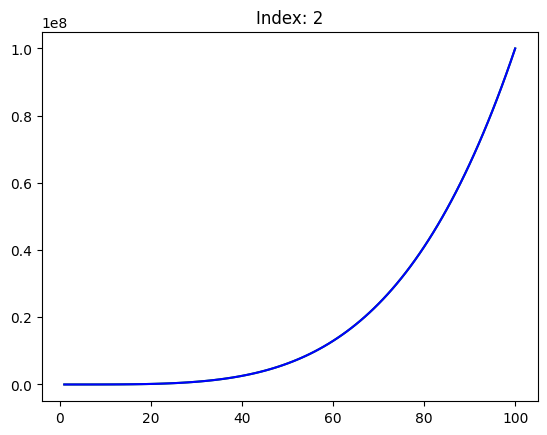

Target:  (((x / 8) * 2) + 1)
Best solution / + 3.00 / x -1.00 + -3.00 - - + ^ -2.00 / 5.00 -5.00 6.00 6.00 0.00
Best fitness -106.77325841836733


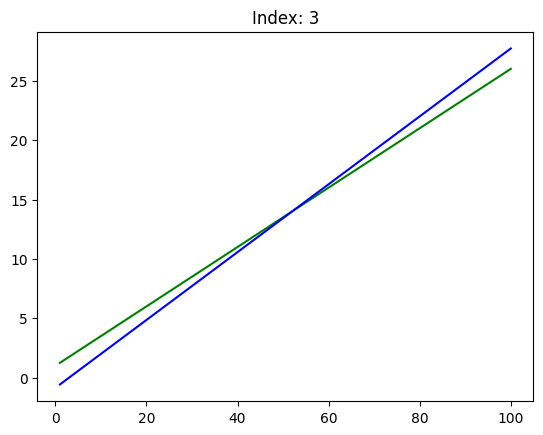

Target:  (((x - 1) - 3) / 5)
Best solution / x 5.00
Best fitness -64.01950000000001


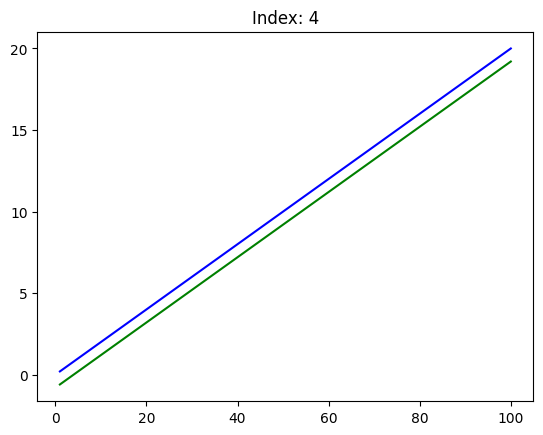

Target:  (x * 5)
Best solution * x 5.00
Best fitness -0.00030000000000000003


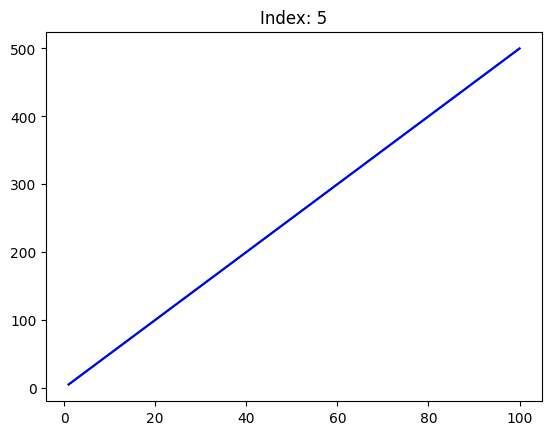

Target:  (x + 2)
Best solution - - x + -3.00 4.00 - * * -1.00 -3.00 ^ - -6.00 -5.00 9.00 / 0.00 * 5.00 ^ 6.00 5.00
Best fitness -0.0023


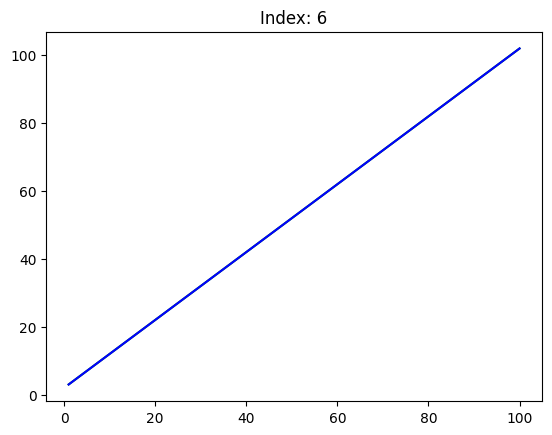

Target:  ((x + 1) * 7)
Best solution * x 7.00
Best fitness -4901.4703


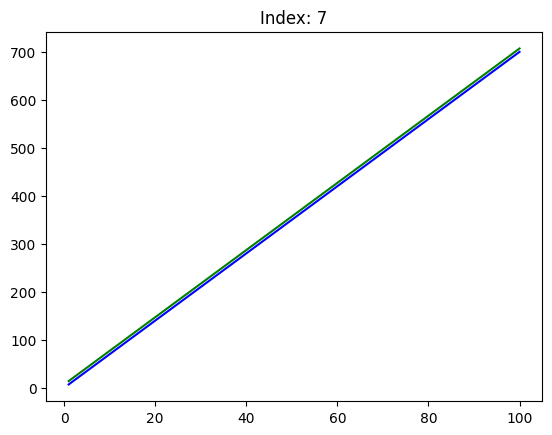

Target:  ((x + 2) ** 9)
Best solution / - ^ + x + 6.00 9.00 9.00 ^ * 10.00 -12.00 8.00 3.00
Best fitness -2.9607226240072336e+34


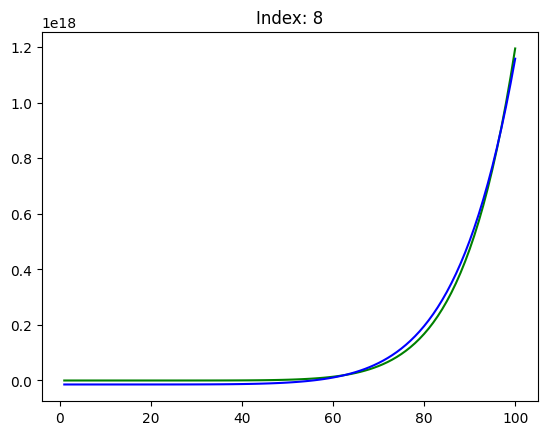

Target:  (x * 2)
Best solution + x x
Best fitness -0.00030000000000000003


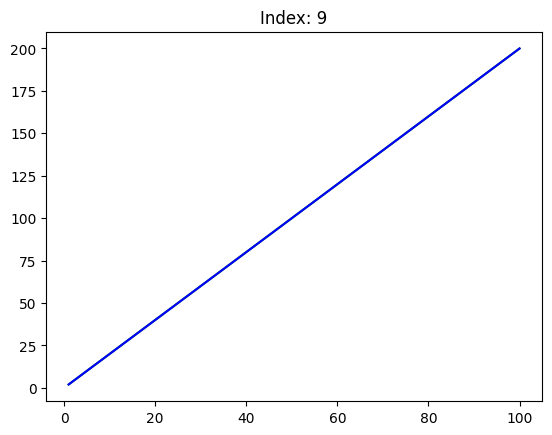

Target:  (((x ** 8) * 5) / 3)
Best solution ^ - -6.00 x 8.00
Best fitness -2.2175058840074493e+30


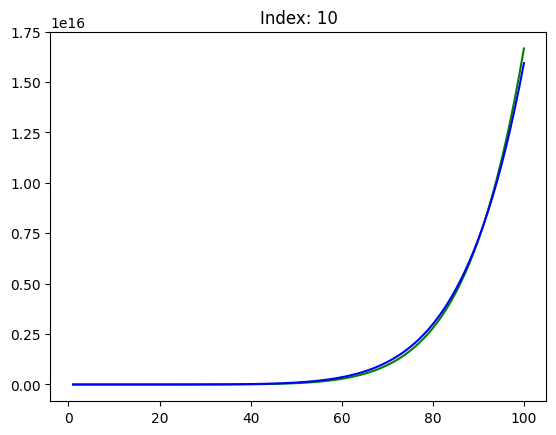

Target:  (x / 7)
Best solution / + / 0.00 + -8.00 -6.00 x 7.00
Best fitness -0.0009000000000000001


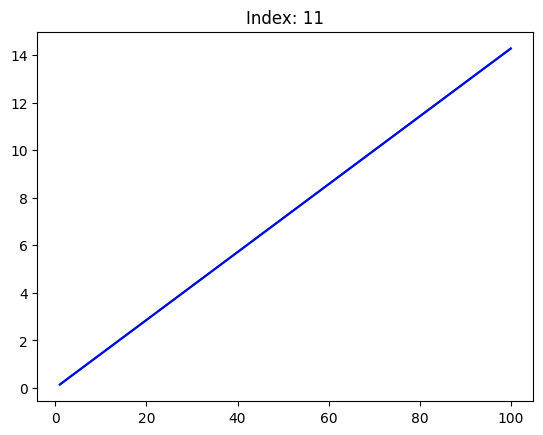

Target:  (((x - 2) + 4) * 5)
Best solution - + 4.00 + 1.00 10.00 * + -2.00 + - -4.00 * / -4.00 4.00 x 5.00 -5.00
Best fitness -0.0019


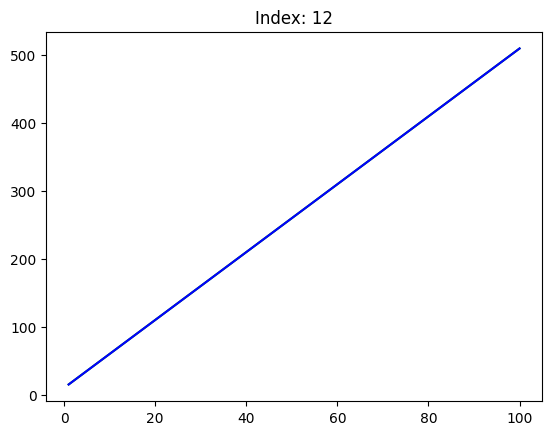

Target:  ((x / 9) / 7)
Best solution / / x -7.00 -9.00
Best fitness -0.0005


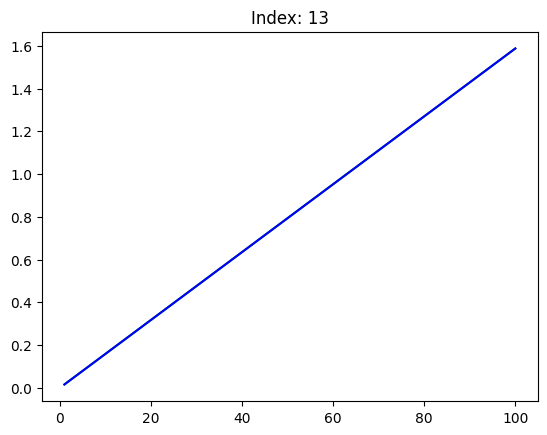

Target:  (x ** 4)
Best solution + ^ x + 4.00 * 7.00 - / ^ * ^ -6.00 -4.00 10.00 / * / + ^ -6.00 4.00 9.00 -8.00 -6.00 4.00 / - + 0.00 0.00 + 3.00 -1.00 -7.00 ^ + ^ 7.00 6.00 -8.00 + 6.00 -10.00 ^ + - -4.00 10.00 + ^ * -4.00 0.00 x + -10.00 - ^ 4.00 * 9.00 1.00 x -9.00
Best fitness -0.006500000000000001


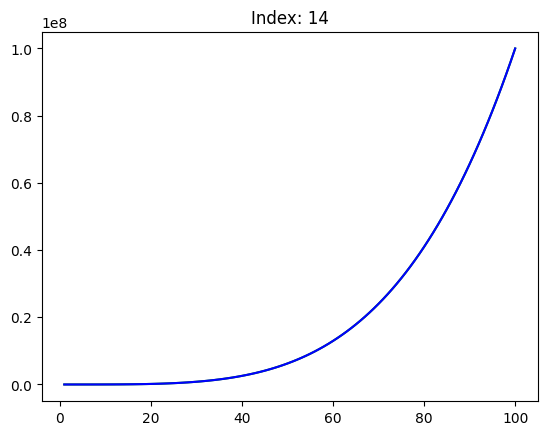

Target:  ((x * 7) - 2)
Best solution * + ^ -12.00 * 0.00 / 0.00 x -8.00 - + -4.00 4.00 x
Best fitness -400.60150000000004


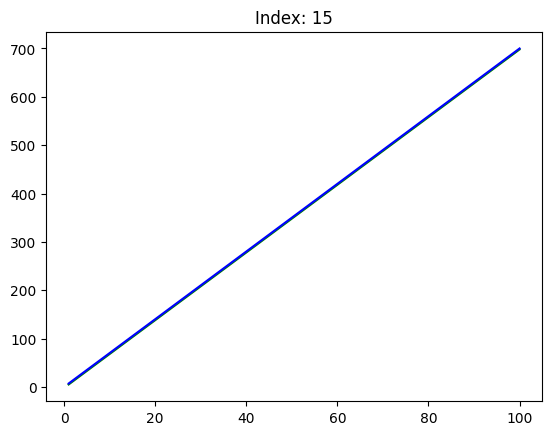

Target:  (((x - 2) * 2) ** 6)
Best solution - -7.00 * - 103.00 ^ / -4.00 x -9.00 -17.00
Best fitness -8.167622060793548e+26


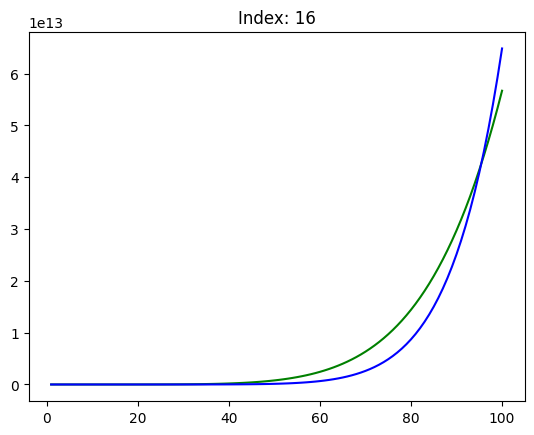

Target:  (((x ** 4) - 8) ** 7)
Best solution - ^ x - - x - - * -9.00 -7.00 1.00 ^ 9.00 -3.00 10.00 / * -5.00 -4.00 * 2.00 1.00
Best fitness -1.2922380301648062e+112


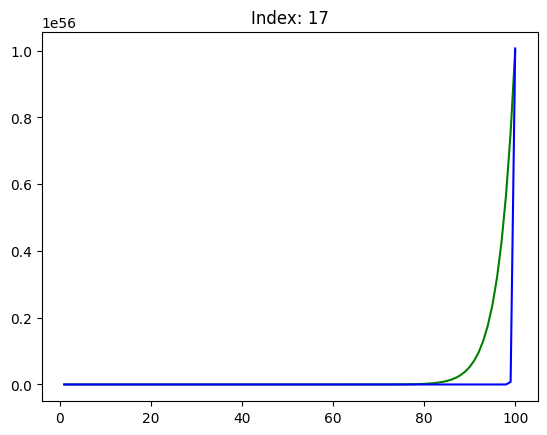

Target:  (x + 4)
Best solution - x -4.00
Best fitness -0.00030000000000000003


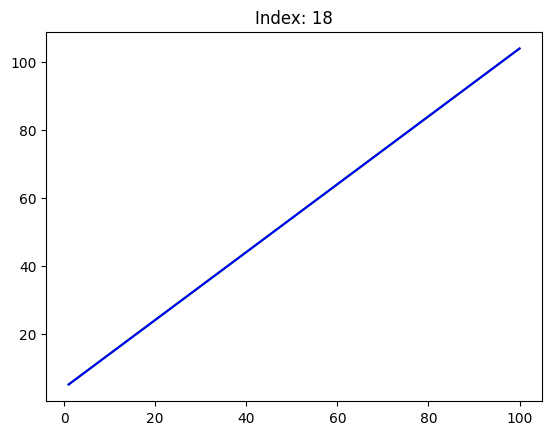

Target:  (((x ** 2) ** 7) * 5)
Best solution * ^ - -1.00 6.00 ^ 2.00 5.00 3.00
Best fitness -8.65613880279125e+57


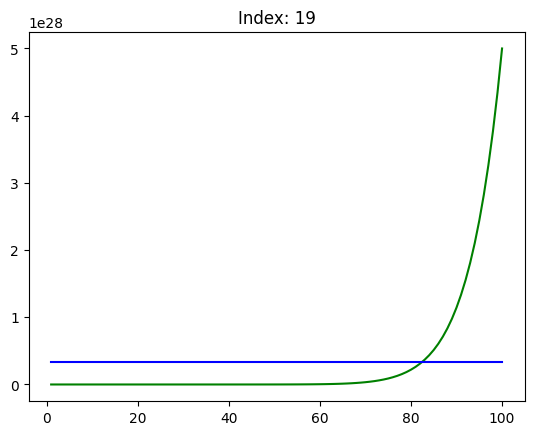

Target:  (((x * 4) * 4) ** 6)
Best solution ^ - x - 8.00 -6.00 10.00
Best fitness -2.233827801588702e+38


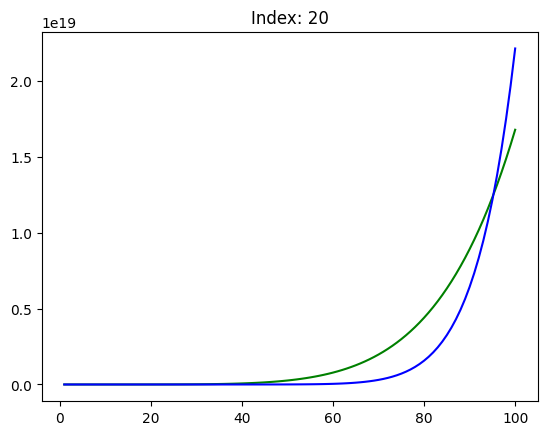

Target:  (((x * 5) - 4) / 6)
Best solution - / / ^ 4.00 2.00 + - * x 0.00 5.00 9.00 -7.00 * / 8.00 - * -56.00 - * / 0.00 / -4.00 - -1.00 4.00 6.00 ^ -3.00 -6.00 2.00 / x 5.00
Best fitness -0.22851228894966008


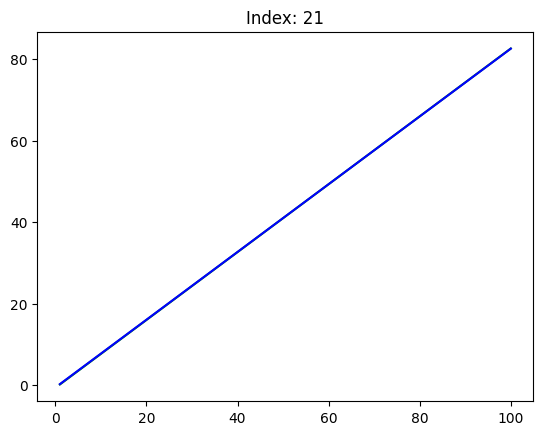

Target:  ((x - 4) / 9)
Best solution / - x * -1.00 -4.00 9.00
Best fitness -0.0007


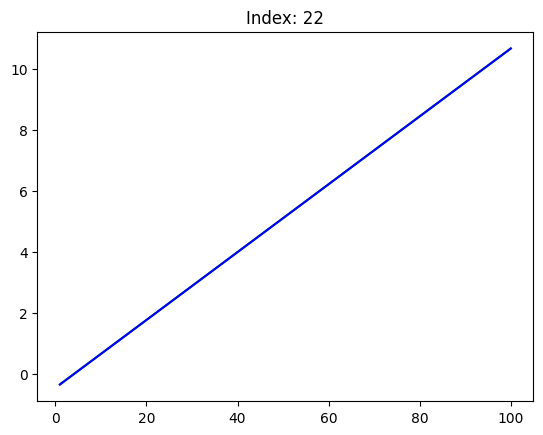

Target:  ((x ** 1) ** 7)
Best solution ^ - x 0.00 7.00
Best fitness -0.0005


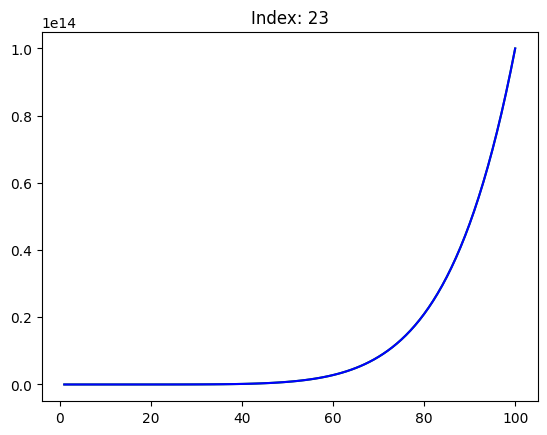

Target:  (((x ** 6) * 8) ** 4)
Best solution * ^ + ^ + -6.00 / - 7.00 -5.00 x 8.00 93.00 8.00 + / - + 9.00 1.00 + x x -3.00 -5.00
Best fitness -2.563250182633739e+103


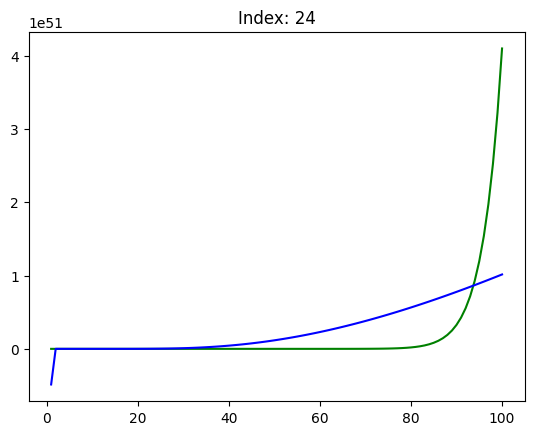

Target:  (((x / 5) / 2) + 7)
Best solution + + * + / -12.00 + * 7.00 -8.00 ^ 4.00 5.00 3.00 8.00 -7.00 - * -7.00 * / - - 9.00 - / -1.00 6.00 12.00 -10.00 - 5.00 ^ 3.00 7.00 - x 19.00 + 7.00 1.00
Best fitness -0.004131493098715428


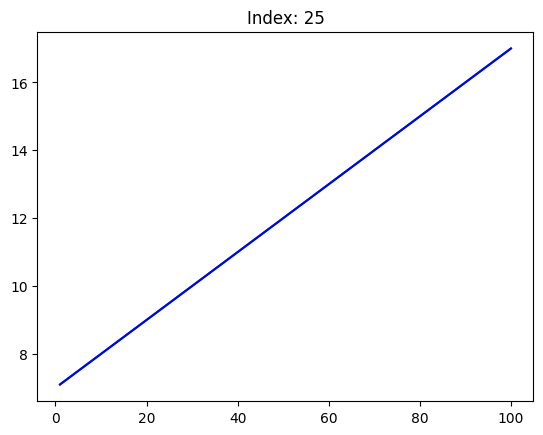

Target:  (x - 7)
Best solution - x 7.00
Best fitness -0.00030000000000000003


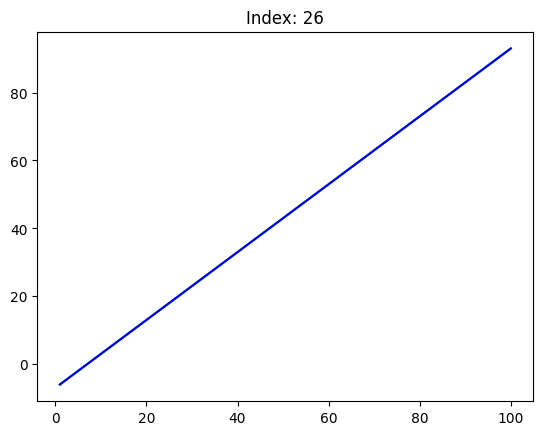

Target:  (((x * 3) / x) ** 4)
Best solution ^ 3.00 4.00
Best fitness -0.00030000000000000003


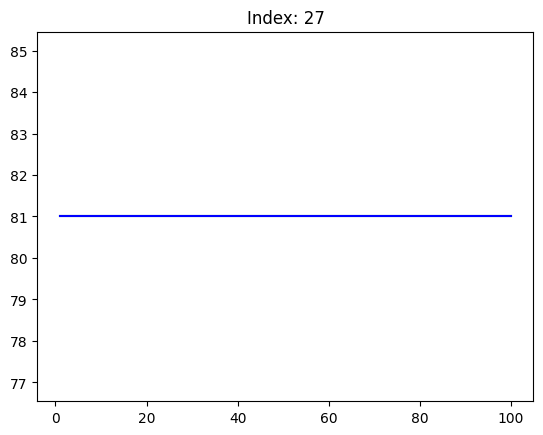

Target:  (((x + 8) - 7) - 6)
Best solution + x -5.00
Best fitness -0.00030000000000000003


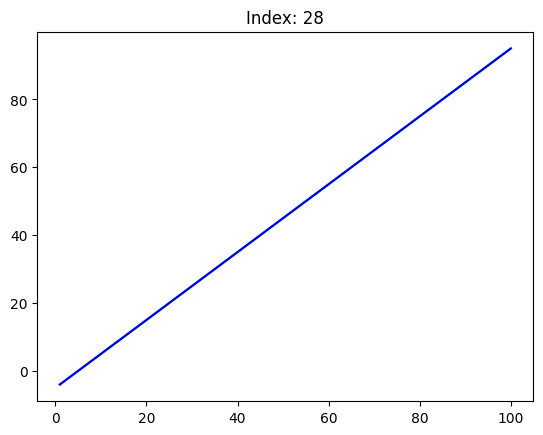

Target:  ((x ** 9) / 9)
Best solution + * -10.00 + 88.00 / ^ + / -3.00 2.00 x 8.00 / / - + / 11.00 / -3.00 4.00 x 1.00 x -1.00 - + -1.00 -9.00 1.00
Best fitness -2.575293883855365e+32


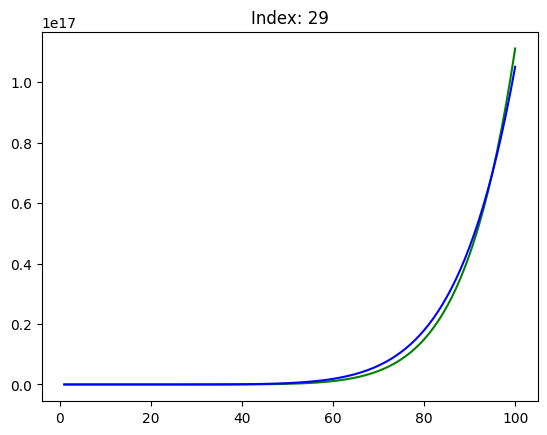

Target:  (x + 6)
Best solution + x 6.00
Best fitness -0.00030000000000000003


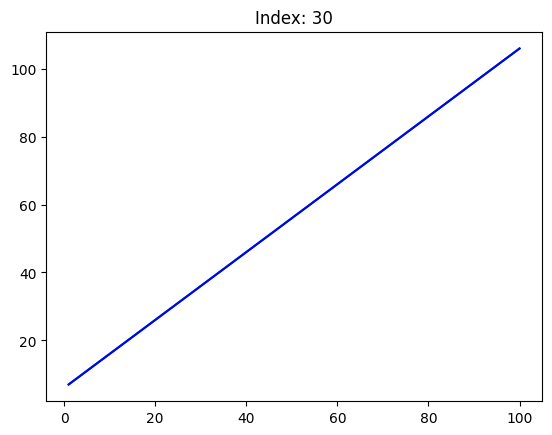

Target:  (x / 9)
Best solution / x 9.00
Best fitness -0.00030000000000000003


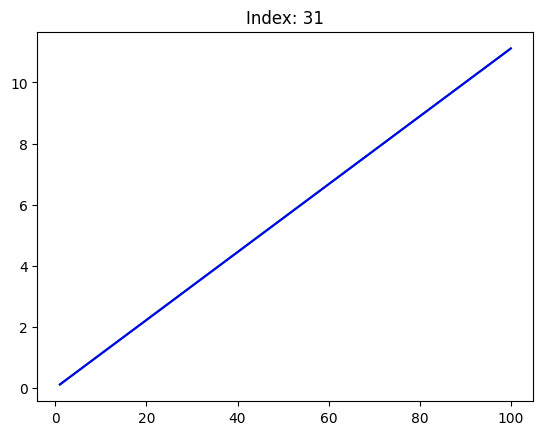

Target:  ((x / 5) + 9)
Best solution * + 4.00 / 8.00 / * * -7.00 * + 6.00 * + -2.00 4.00 7.00 -6.00 + - -3.00 - 9.00 - 9.00 -9.00 -4.00 -10.00 / x + ^ + -6.00 7.00 * + / * -8.00 - -5.00 ^ -1.00 3.00 * -5.00 / -3.00 -2.00 0.00 3.00 - 3.00 / -1.00 / 9.00 x
Best fitness -517.626179330374


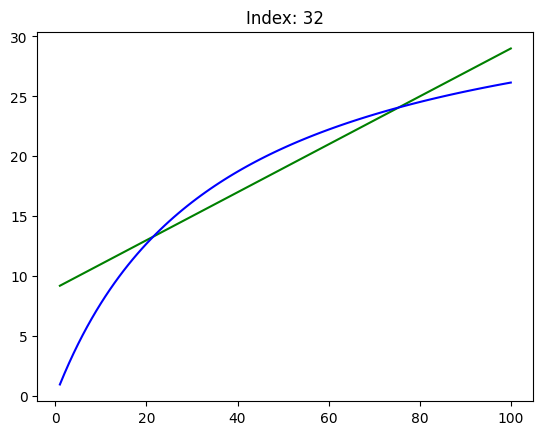

Target:  ((x ** 9) / 3)
Best solution * ^ -5.00 10.00 + -34.00 - - -40.00 * 2.00 / ^ x 6.00 * -10.00 7.00 45.00
Best fitness -2.2712481357211416e+34


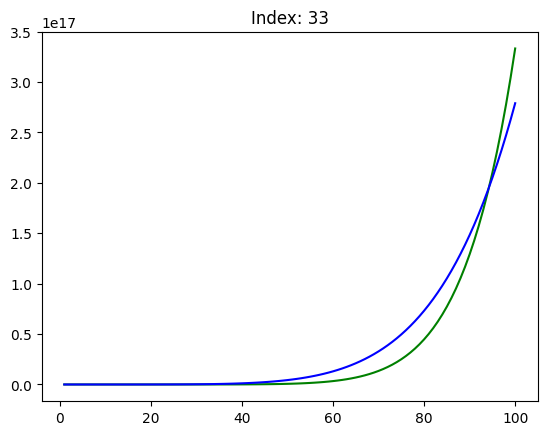

Target:  ((x ** 9) ** 1)
Best solution ^ x - 7.00 -2.00
Best fitness -0.0005


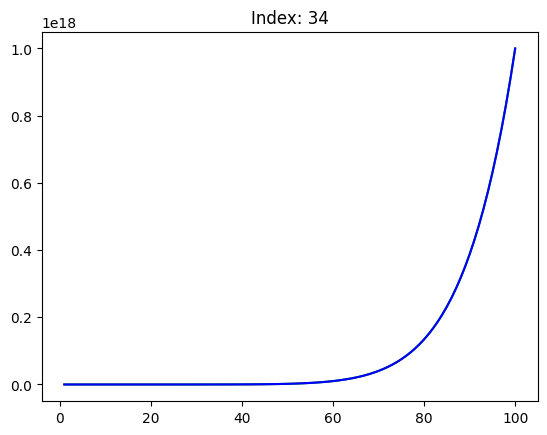

Target:  ((x / 6) - 7)
Best solution / - - + 9.00 + 3.00 8.00 - - x 10.00 4.00 -8.00 -6.00
Best fitness -0.0015


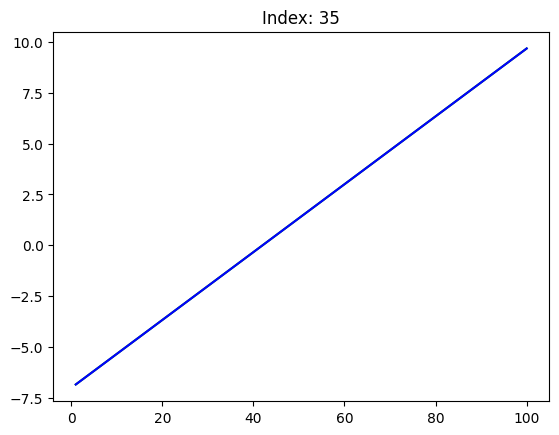

Target:  (x - 8)
Best solution * - / 3.00 / -4.00 -8.00 + + + * - - 8.00 6.00 9.00 ^ ^ + -10.00 -8.00 -3.00 4.00 * -5.00 -4.00 * -10.00 3.00 / - * - + 2.00 -2.00 -9.00 -1.00 + * * 5.00 -5.00 -5.00 + -7.00 + 9.00 x -9.00 - * 0.00 ^ -6.00 -9.00 9.00
Best fitness -0.0057


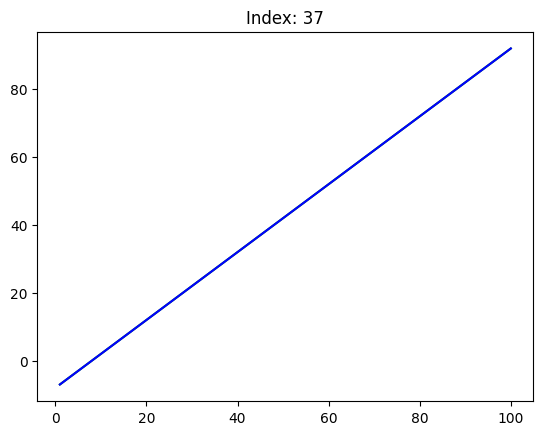

Target:  (((x / 3) / 4) ** 6)
Best solution / - + / 6.00 ^ 8.00 6.00 ^ + + 4.00 7.00 - x 2.00 3.00 104.00 6.00
Best fitness -109400182521.89143


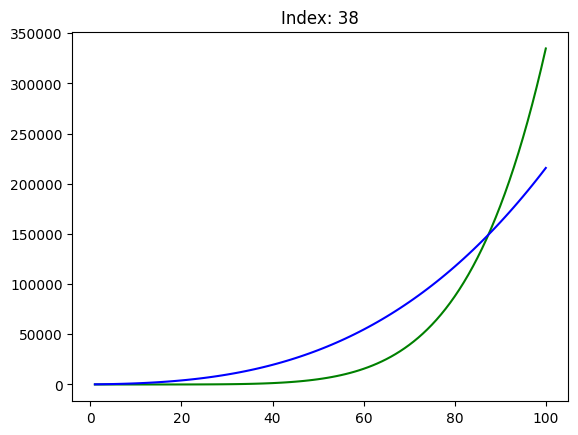

Target:  (x / 2)
Best solution - + * 3.00 / x - * -2.00 / -10.00 -8.00 -9.00 -3.00 -5.00
Best fitness -123.78156656804734


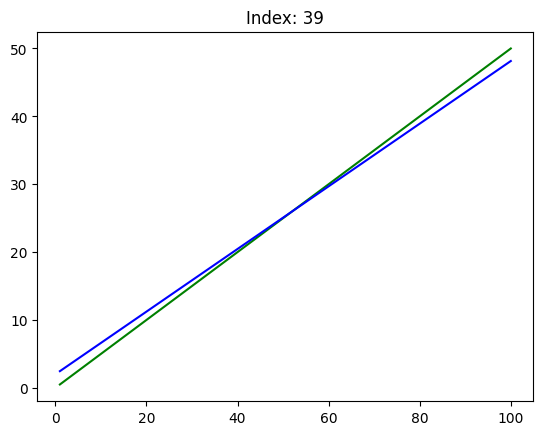

Target:  (((x * 7) ** 4) + 3)
Best solution ^ - - * * 2.00 x -3.00 * -3.00 1.00 + - * x / + 4.00 * - / -6.00 9.00 * 7.00 0.00 -6.00 7.00 -8.00 / / * 2.00 x + -4.00 5.00 -10.00 4.00
Best fitness -1.1293763267099916e+19


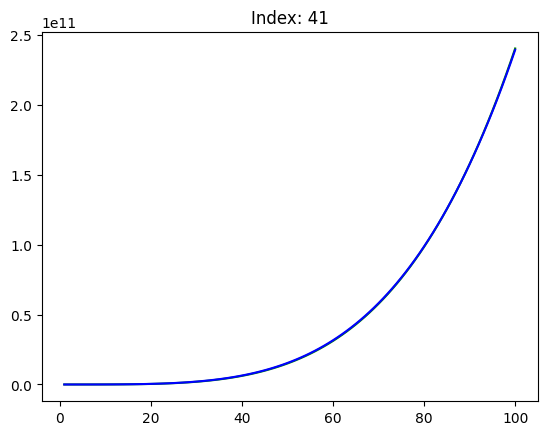

Target:  (x * 3)
Best solution / - -10.00 2.00 / - -10.00 + -6.00 * + 5.00 + - 6.00 2.00 -9.00 / 6.00 x x
Best fitness -0.0021000000000000003


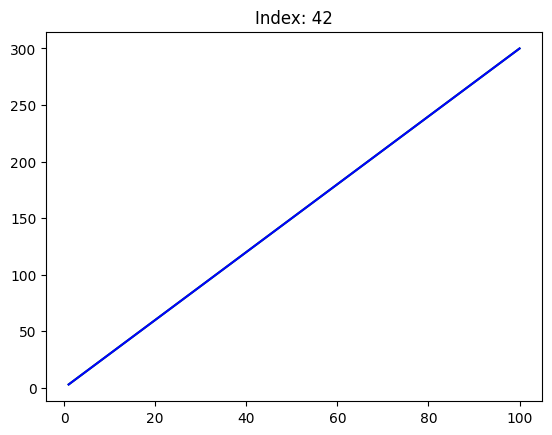

Target:  ((x ** 1) + 9)
Best solution + x 9.00
Best fitness -0.00030000000000000003


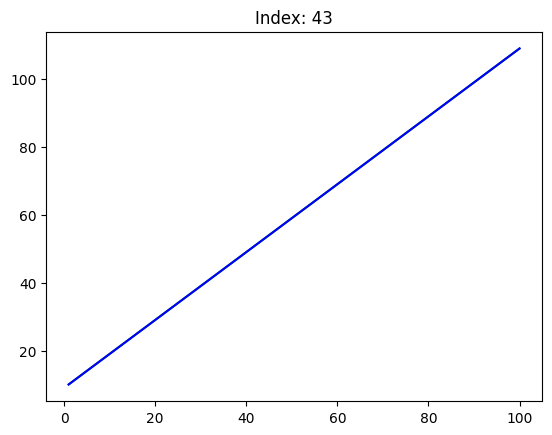

Target:  ((x * 2) / 7)
Best solution * 3.00 + ^ + 5.00 / -4.00 9.00 -1.00 / x - 6.00 -5.00
Best fitness -14.077110049576367


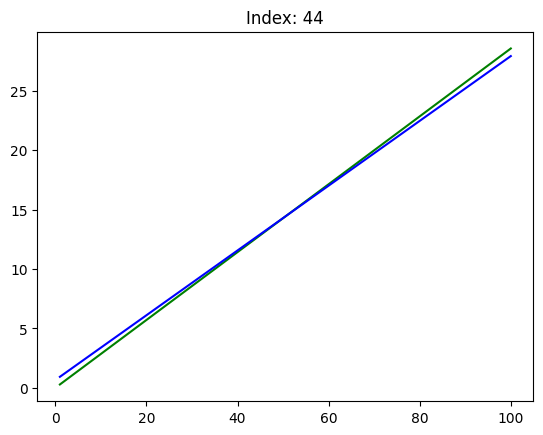

Target:  ((x / 9) / 3)
Best solution / / + - 4.00 0.00 / 8.00 - 8.00 ^ -3.00 0.00 * - - 3.00 - -5.00 / 5.00 4.00 / ^ ^ 8.00 + + ^ -5.00 5.00 -1.00 -11.00 + -4.00 - + ^ -8.00 2.00 -4.00 -3.00 5.00 / -3.00 x - / -10.00 2.00 / 7.00 / / 9.00 x * -6.00 * ^ -4.00 -10.00 -11.00
Best fitness -0.006317484400518471


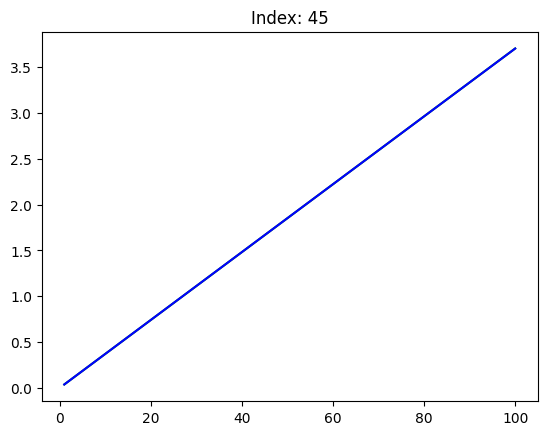

Target:  (((x - 8) / x) / 6)
Best solution / + - x * -9.00 ^ 8.00 * / -1.00 ^ / * 4.00 3.00 x -3.00 3.00 -9.00 * x * - -6.00 * / ^ 8.00 3.00 * + 9.00 -6.00 * -8.00 * -5.00 4.00 -4.00 -4.00
Best fitness -0.011224395659635341


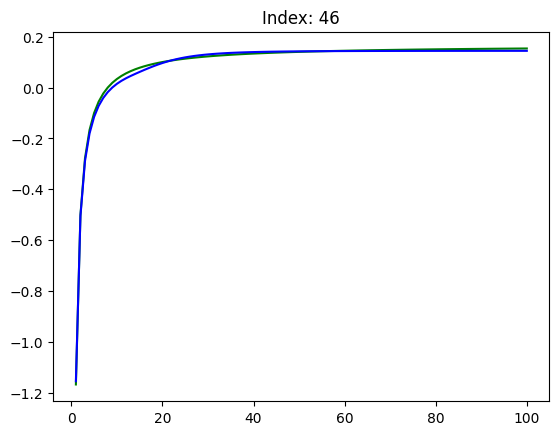

Target:  (((x + 7) + 6) * 9)
Best solution * - * 5.00 x -33.00 2.00
Best fitness -83408.34569999999


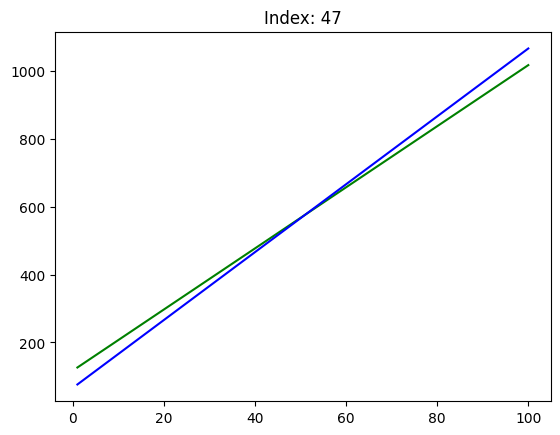

Target:  (((x / 5) - 7) + 7)
Best solution / x 5.00
Best fitness -0.00030000000000000003


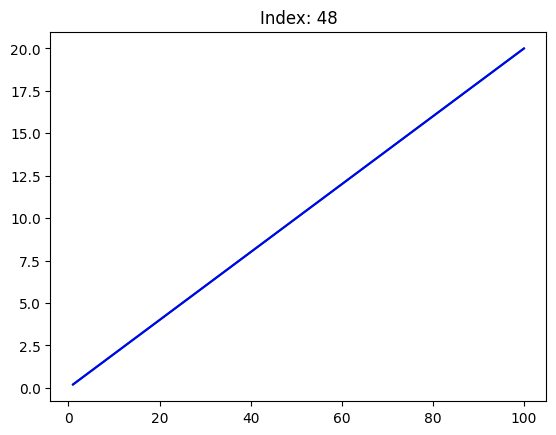

Target:  (((x / 8) / 5) / 6)
Best solution * / / - -1.00 0.00 -7.00 * 7.00 / / - * * -4.00 7.00 10.00 -31.00 + + -2.00 x 3.00 5.00 -10.00
Best fitness -0.0029335775545774653


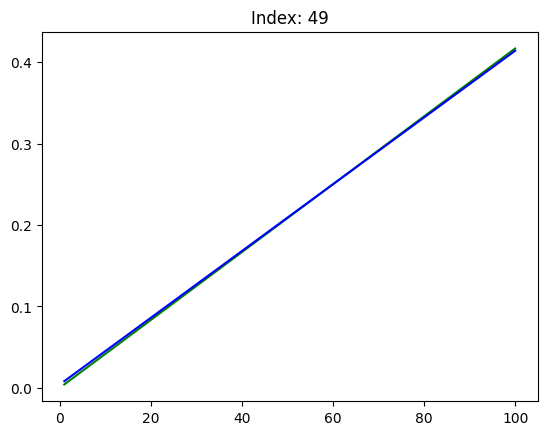

Target:   1*x**2 + 4*x + 5
Best solution - x * - 0.00 x + 6.00 + x -3.00
Best fitness -2502.7511000000004


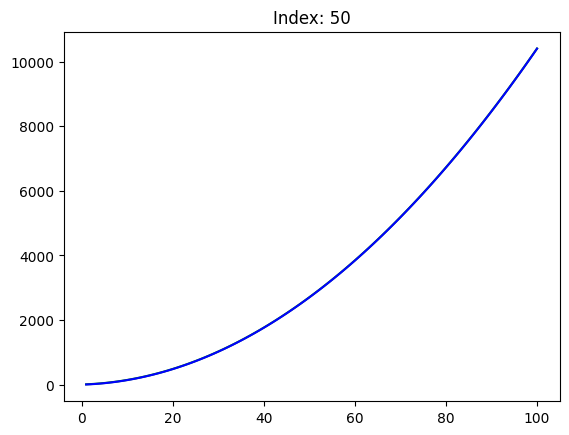

Target:   -2*x**4 + -3*x**3 + -1*x**2 + -4*x + +2
Best solution / / - x 29.00 - + * + -2.00 * ^ x -2.00 - x / -6.00 10.00 0.00 / - x + -3.00 - -6.00 ^ / 10.00 ^ * -4.00 x 3.00 -8.00 ^ -7.00 x / / 5.00 - 5.00 4.00 + 13.00 - ^ -5.00 10.00 + / 27.00 - - * -3.00 - 7.00 6.00 5.00 -7.00 -29.00 ^ 1.00 5.00
Best fitness -4.3348348388246664e+16


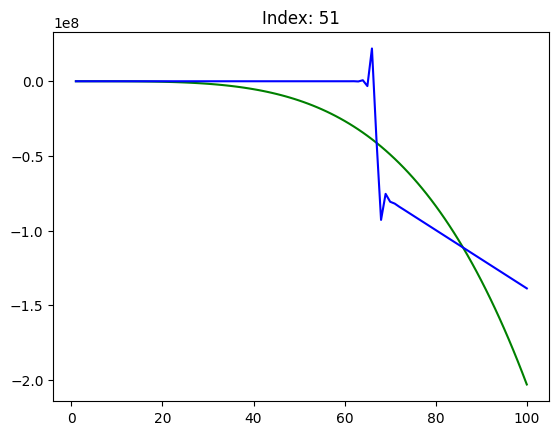

Target:   -4*x**5 + -4*x + 5
Best solution / / 8.00 -2.00 ^ x -5.00
Best fitness -5217749.872133971


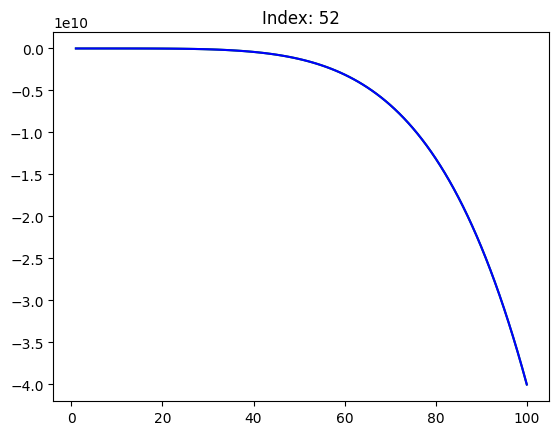

Target:   -1*x**4 + 4*x**3 + 4*x**2 + -3*x + 4
Best solution * + * ^ -2.00 10.00 * * - x - 4.00 - -1.00 + -10.00 * 7.00 3.00 -2.00 4.00 100.00 x
Best fitness -6445689064994389.0


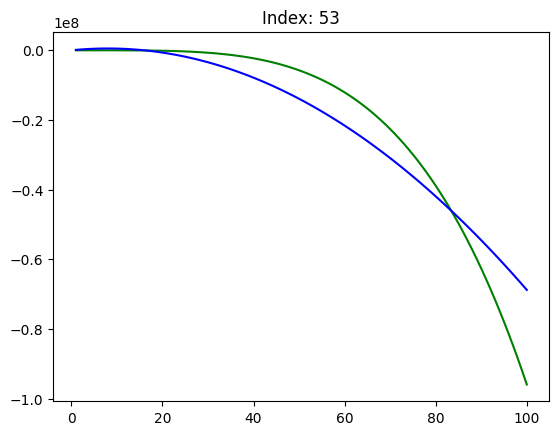

Target:   -4*x**5 + 1*x**3 + -2*x**2 + -1*x + -1
Best solution * / / * * -4.00 + 2.00 -8.00 -5.00 * / - -4.00 -2.00 5.00 -9.00 - x - - ^ * - -10.00 9.00 -7.00 / -1.00 + / * 6.00 * -9.00 2.00 / x x -7.00 -10.00 6.00 ^ * * -2.00 ^ x ^ 7.00 - -10.00 / * 4.00 7.00 -4.00 * -8.00 * ^ 1.00 x / 10.00 * x + - x -9.00 9.00 -6.00
Best fitness -1.478828955989359e+21


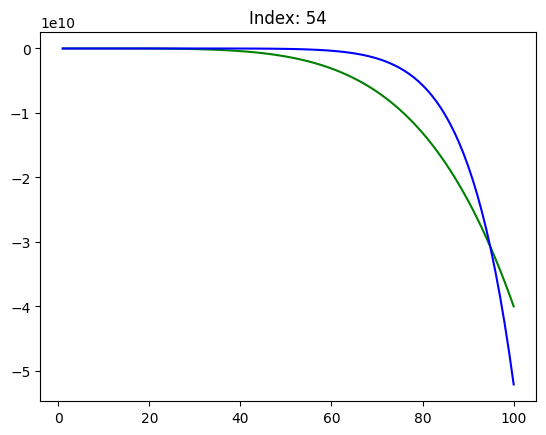

Target:   -4*x + +2
Best solution + + 9.00 + 0.00 -7.00 * -4.00 x
Best fitness -0.0009000000000000001


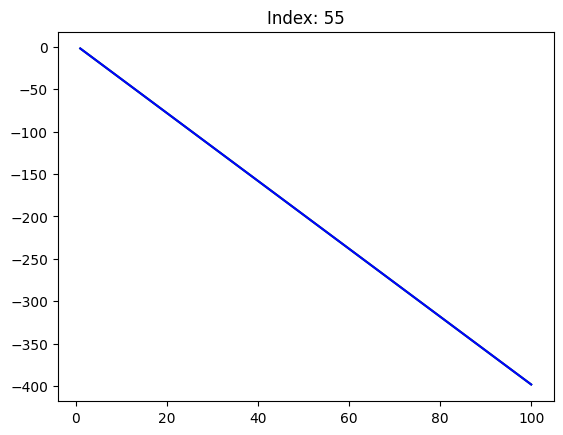

Target:   -4*x**4 + -2*x**3 + 1*x + -2
Best solution - - * -6.00 - * * 20.00 -20.00 * 19.00 21.00 ^ 8.00 7.00 * + * / 10.00 ^ x -3.00 -3.00 x - * * -1.00 0.00 10.00 - 6.00 - -6.00 / - -6.00 9.00 ^ -3.00 3.00 / x / 1.00 -26.00
Best fitness -1.8574315638337296e+16


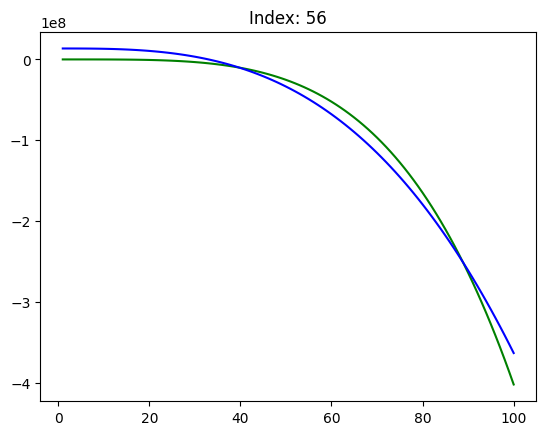

Target:   4*x**2 + -2*x + +2
Best solution / - / * x x 6.00 - 10.00 -17.00 ^ -5.00 -2.00
Best fitness -31152399.152105525


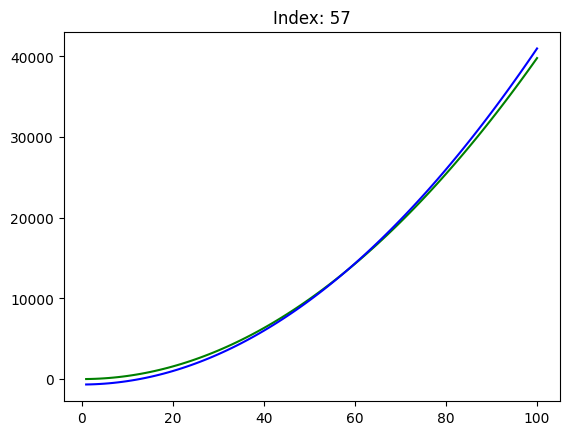

Target:   -4*x**4 + 1*x + -2
Best solution + - * * 0.00 / + - - x -6.00 10.00 9.00 - * -8.00 * + -10.00 - -3.00 4.00 -5.00 ^ 0.00 x * -9.00 + * - - x -7.00 -7.00 * ^ -7.00 7.00 -8.00 + + / 5.00 -4.00 * * -10.00 - 5.00 -6.00 + + * 8.00 2.00 9.00 - - 0.00 9.00 -6.00 * + ^ 10.00 / -3.00 * x -5.00 9.00 + + + - 7.00 3.00 -6.00 x ^ 9.00 -3.00 -101.00 * - - * 8.00 -8.00 / + x -3.00 / / 1.00 5.00 9.00 + -5.00 5.00 * * x + -2.00 x 8.00
Best fitness -2.6943241072575668e+16


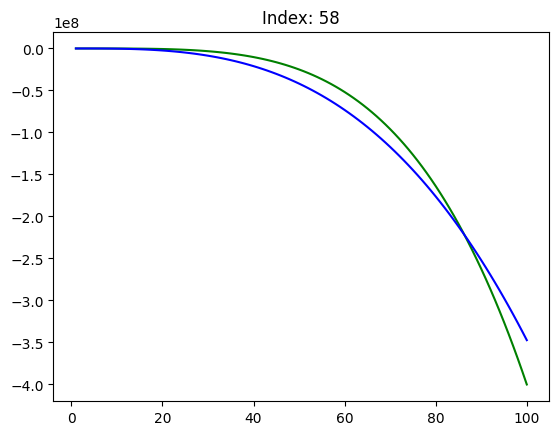

Target:   1*x**3 + -2*x**2 + -1*x + 4
Best solution ^ x + + + 4.00 5.00 -4.00 -2.00
Best fitness -8305697676.3439


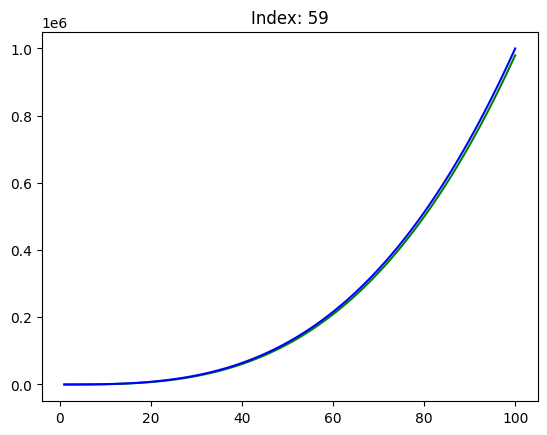

Target:   2*x**4 + -3*x**2 + 1*x + 4
Best solution ^ - x * / -7.00 / / 4.00 -9.00 ^ -5.00 -6.00 - ^ -8.00 3.00 ^ 5.00 6.00 4.00
Best fitness -3443427964306715.5


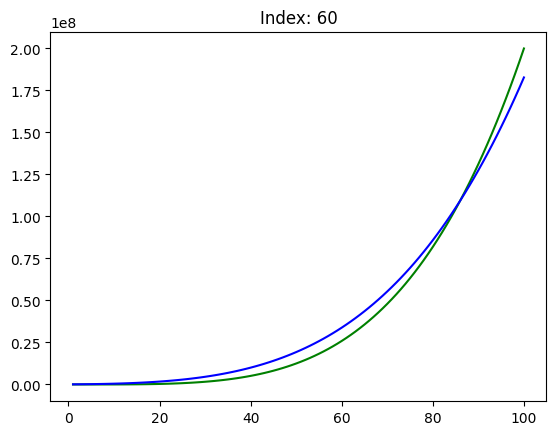

Target:   1*x**4 + -2*x**3 + 2*x**2 + -1*x + +2
Best solution ^ x 4.00
Best fitness -57822631065033.45


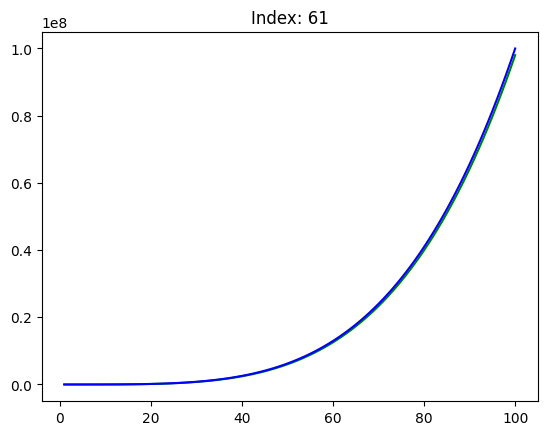

Target:   -1*x**5 + 1*x + +1
Best solution ^ * -1.00 x 5.00
Best fitness -348724.2755


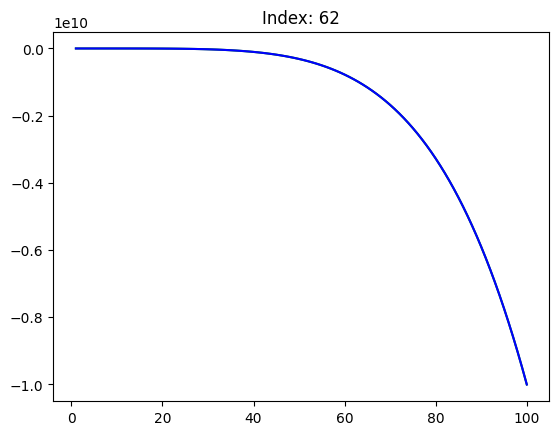

Target:   -3*x**5 + -3*x**3 + 1*x**2 + -4*x + 4
Best solution - ^ / * -8.00 / -8.00 6.00 - * 1.00 + + / + -7.00 0.00 3.00 -1.00 -2.00 - 6.00 + - / + x 61.00 x + 7.00 10.00 + * / * x -4.00 + * 10.00 -4.00 -4.00 - -1.00 x x - 3.00 8.00 * - x - 8.00 x ^ - -9.00 x 4.00
Best fitness -1.5179357942394621e+18


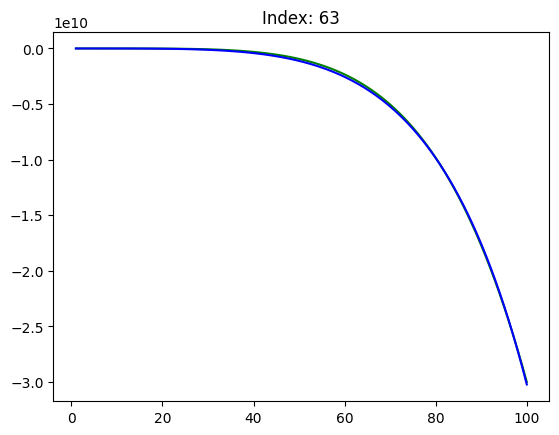

Target:   1*x**5 + 2*x**4 + -1*x**2 + -4*x + +1
Best solution * / ^ x - -4.00 * -9.00 ^ + ^ + ^ 1.00 4.00 0.00 -7.00 8.00 ^ 8.00 -4.00 9.00 9.00
Best fitness -6760864028800085.0


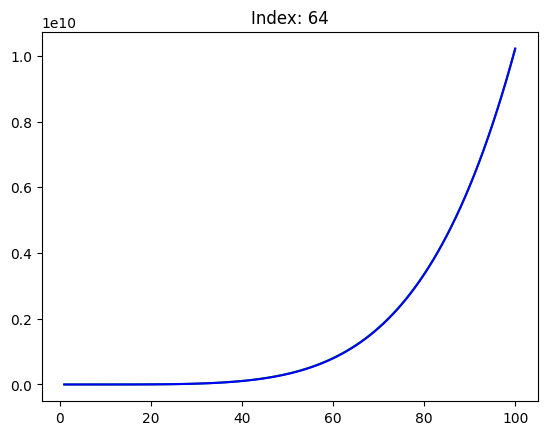

Target:   -1*x**5 + 1*x**3 + 2*x + +1
Best solution * -5.00 + + * 5.00 * 9.00 * ^ 11.00 4.00 -5.00 * / * 6.00 * - / -13.00 -2.00 / x 4.00 9.00 ^ -4.00 - 0.00 10.00 -1.00 + x -82.00
Best fitness -2.1698101943382354e+20


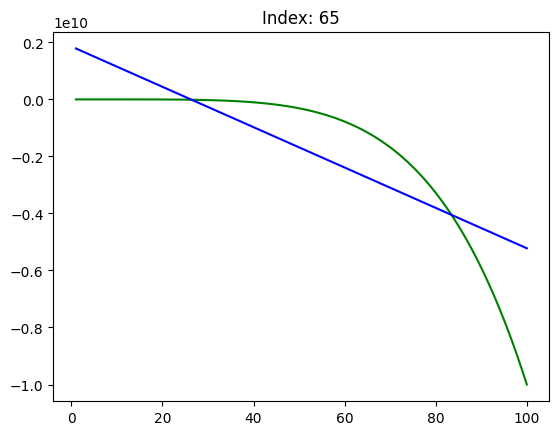

Target:   1*x**4 + -4*x + +3
Best solution ^ x 4.00
Best fitness -5294887.990300001


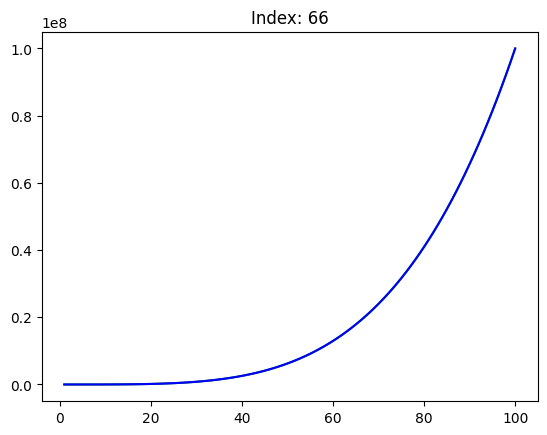

Target:   -1*x**2 + -2*x + +2
Best solution - + -1.00 * -1.00 8.00 - + -1.00 + x * x x * -7.00 * / -8.00 -11.00 8.00
Best fitness -83505.16073636396


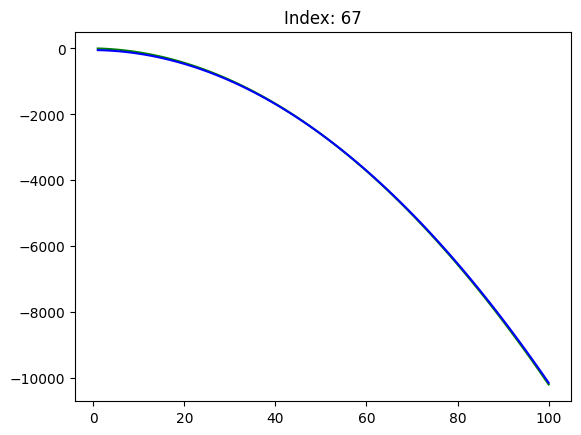

Target:   -3*x**5 + 1*x**4 + 3*x**2 + 2*x + -1
Best solution / * / ^ - - 5.00 ^ 1.00 / 0.00 8.00 + 2.00 x * -4.00 -1.00 / -1.00 -3.00 ^ -10.00 * + -2.00 ^ -1.00 2.00 -3.00 / + / ^ * -6.00 * / x -5.00 10.00 * + 1.00 x 0.00 + 8.00 * ^ -4.00 0.00 / - -8.00 -9.00 -8.00 10.00 ^ - ^ 6.00 * 2.00 3.00 / * * 6.00 / ^ -4.00 -1.00 2.00 7.00 -6.00 0.00
Best fitness -6.886890281869526e+19


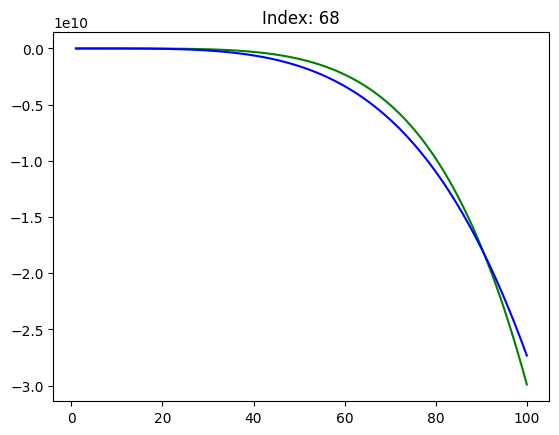

Target:   1*x**5 + -3*x**3 + 3*x + -3
Best solution ^ x 5.00
Best fitness -133119907066581.5


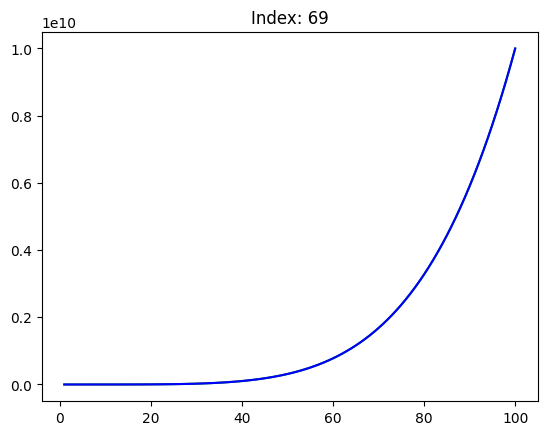

Target:   -3*x**2 + 4*x + -3
Best solution * + * * / -11.00 - - 0.00 2.00 6.00 -5.00 + -1.00 * x / x 7.00 - 4.00 + + 3.00 ^ - * 9.00 -3.00 -1.00 -1.00 2.00 3.00
Best fitness -326258.49296419614


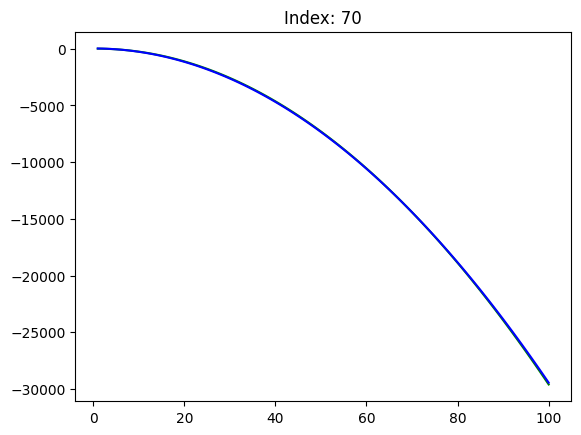

Target:   1*x**5 + -1*x**4 + -2*x + +3
Best solution + + + ^ ^ - ^ + * -8.00 -2.00 -6.00 7.00 0.00 3.00 0.00 23.00 ^ x 5.00 * 26.00 * -26.00 * * + -15.00 -12.00 x -28.00
Best fitness -2.913228570195075e+16


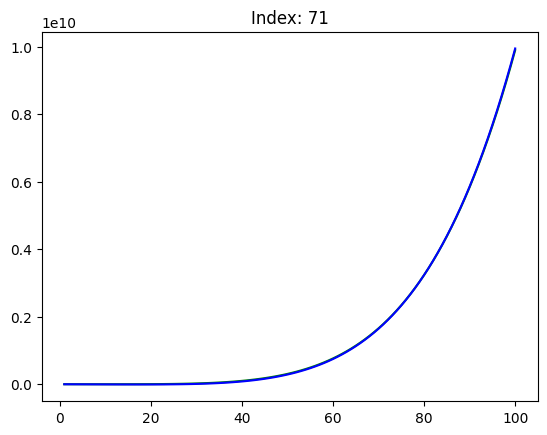

Target:   3*x**3 + 1*x + +1
Best solution ^ - 8.00 -3.00 - * / -8.00 8.00 - / - ^ - * + -3.00 * -8.00 -1.00 10.00 -6.00 ^ 8.00 -1.00 * 9.00 + -6.00 -3.00 x * * 1.00 0.00 7.00 -7.00
Best fitness -727645322369.6106


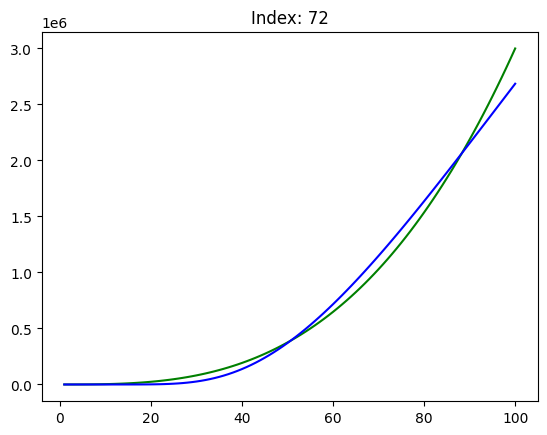

Target:   -4*x**5 + -3*x**4 + 1*x**2 + -1*x + +3
Best solution + -49.00 + ^ / * x * - + -7.00 -1.00 / 9.00 6.00 9.00 ^ -4.00 - 6.00 2.00 7.00 -45.00
Best fitness -3.741923575048321e+20


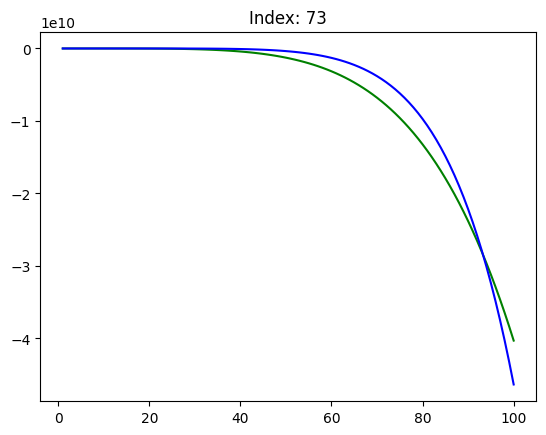

Target:   -4*x**5 + 1*x**3 + 3*x + -3
Best solution + -98.00 / ^ - x / x - 10.00 + 9.00 6.00 5.00 / x / + / + - 9.00 * 6.00 -2.00 -5.00 1.00 * x -5.00 3.00
Best fitness -2.083723007070679e+17


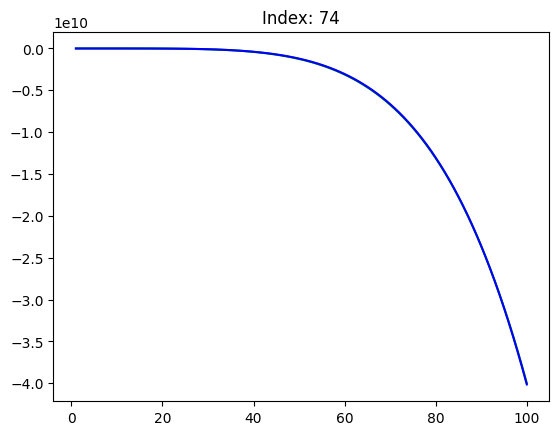

Target:   1*x**4 + -1*x**3 + 3*x + -1
Best solution ^ x 4.00
Best fitness -14782899678861.705


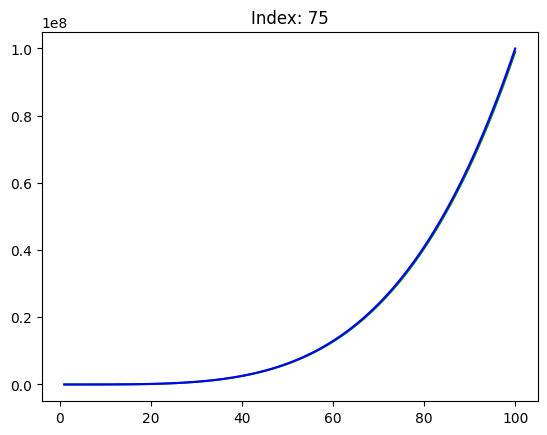

Target:   -2*x**3 + -4*x + -4
Best solution * + - 13.00 x 15.00 * + ^ 6.00 3.00 + 7.00 + - / -49.00 x -20.00 15.00 x
Best fitness -275934973831.893


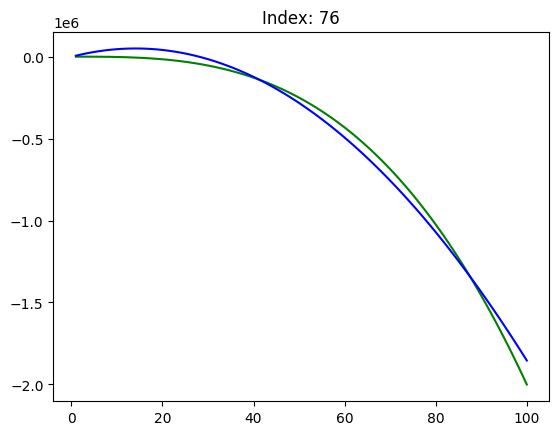

Target:   4*x**4 + 2*x**3 + 4*x**2 + 4*x + -2
Best solution * -1.00 / 4.00 * / + -1.00 - -7.00 ^ - + 0.00 -4.00 -2.00 - * -4.00 1.00 - 4.00 5.00 * / ^ / x 6.00 9.00 -5.00 -5.00 x
Best fitness -1.8000140877275974e+17


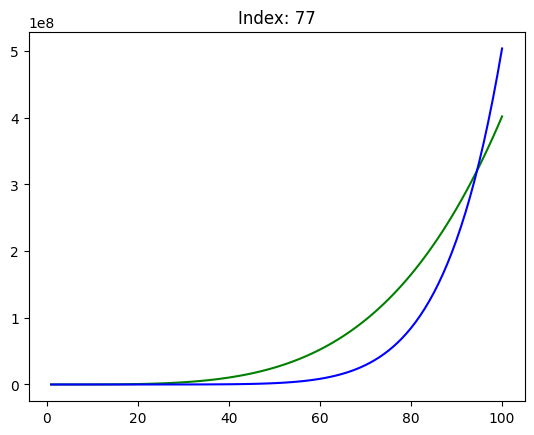

Target:   1*x**5 + -1*x**4 + 1*x**3 + -1*x**2 + 2*x + -4
Best solution ^ x 5.00
Best fitness -1.1365406074006907e+17


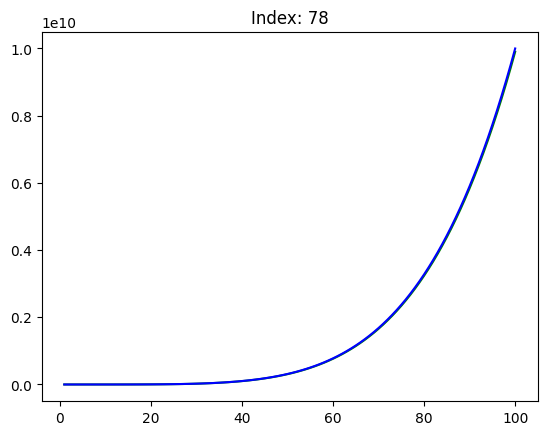

Target:   -2*x + -5
Best solution / - x -2.00 - / -4.00 8.00 / / + -7.00 -10.00 - 9.00 + 5.00 + x + * x - -8.00 4.00 * - / 1.00 9.00 -4.00 -5.00 / 10.00 / - * -3.00 4.00 -1.00 * 7.00 - -10.00 -9.00
Best fitness -0.05874423720233733


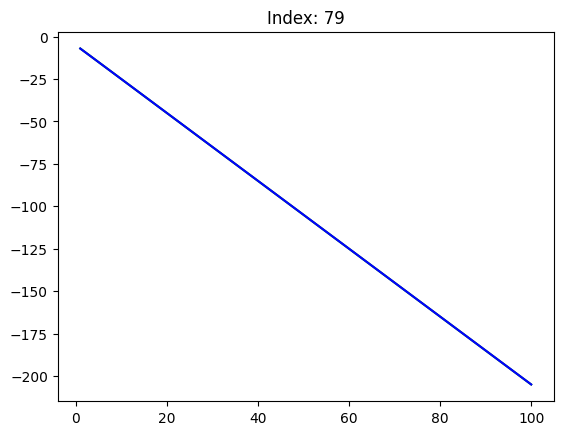

Target:   3*x**5 + -1*x**3 + 2*x**2 + -2*x + -3
Best solution + / 4.00 * -1.00 x * * -2.00 - * 30.00 * * -30.00 -30.00 30.00 * ^ ^ / ^ 3.00 2.00 -4.00 / 4.00 -1.00 / * - + -7.00 - 10.00 -2.00 8.00 ^ -10.00 1.00 -7.00 x x
Best fitness -1.3419418234022868e+21


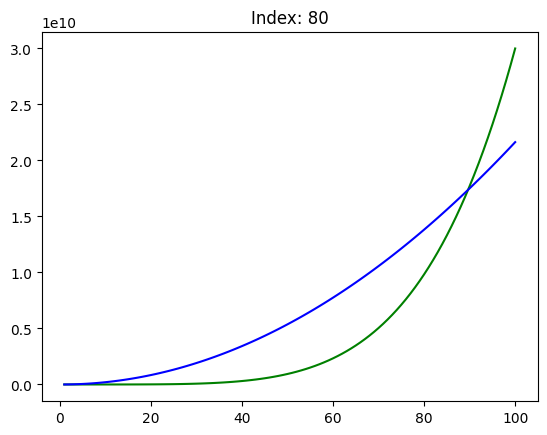

Target:   -3*x**5 + -2*x**4 + 2*x**3 + 2*x**2 + 1*x + +2
Best solution + + / / - + 3.00 10.00 -3.00 + / 1.00 * * / * 8.00 -2.00 6.00 9.00 / 3.00 4.00 / -10.00 ^ 5.00 6.00 ^ x + 5.00 -9.00 / * ^ 3.00 * -3.00 -4.00 * -19.00 -17.00 - 3.00 + + 5.00 -1.00 * -9.00 * + 1.00 -2.00 0.00 + ^ + 3.00 10.00 8.00 59.00
Best fitness -6.0121978275732e+19


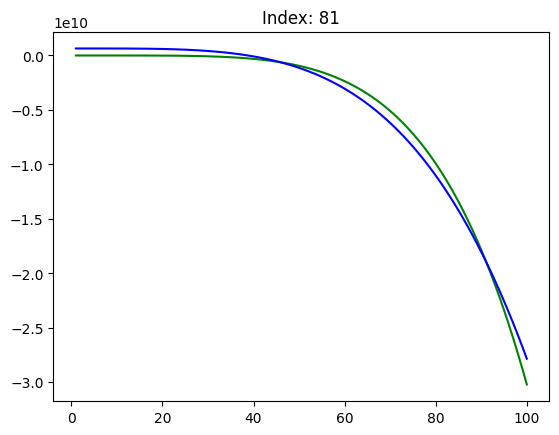

Target:   3*x**5 + 4*x**4 + 4*x**2 + -4*x + 5
Best solution * - * ^ ^ + 8.00 ^ -4.00 -2.00 - 8.00 10.00 -2.00 * + + 6.00 1.00 3.00 * 2.00 x 101.00 + + + + x -8.00 - -7.00 -5.00 / + 0.00 5.00 / - ^ + 6.00 4.00 ^ - -5.00 -8.00 -4.00 ^ -3.00 0.00 9.00 * -10.00 5.00
Best fitness -2.813555171990126e+21


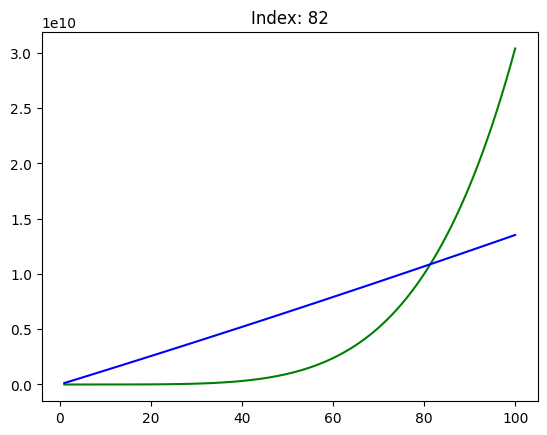

Target:   2*x**5 + -2*x**3 + -3*x**2 + -2*x + -3
Best solution + + -2.00 + * 99.00 - x -12.00 - -7.00 7.00 + ^ x 5.00 -9.00
Best fitness -9.61079364018814e+20


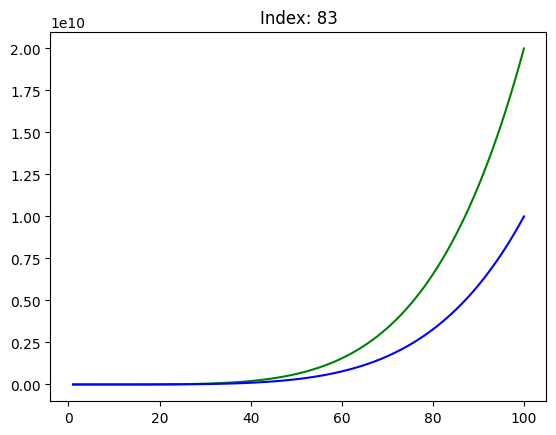

Target:   1*x**4 + -4*x**3 + -1*x + -3
Best solution ^ x 4.00
Best fitness -236739441533290.28


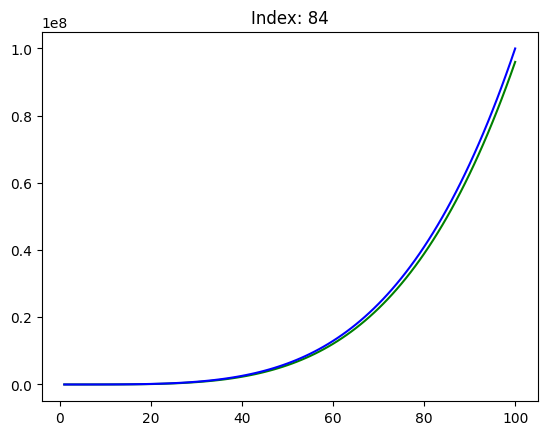

Target:   -4*x**5 + 1*x + -1
Best solution * -9.00 / * + -11.00 * / 0.00 1.00 ^ -4.00 x - * * -19.00 -7.00 * -10.00 * ^ * / 11.00 -4.00 / + 0.00 3.00 * 2.00 -10.00 * 8.00 1.00 - - -7.00 -14.00 -9.00 13.00 ^ / * -5.00 / - - 30.00 * 5.00 9.00 x - -10.00 -5.00 -2.00 -4.00
Best fitness -4.7776096523886874e+20


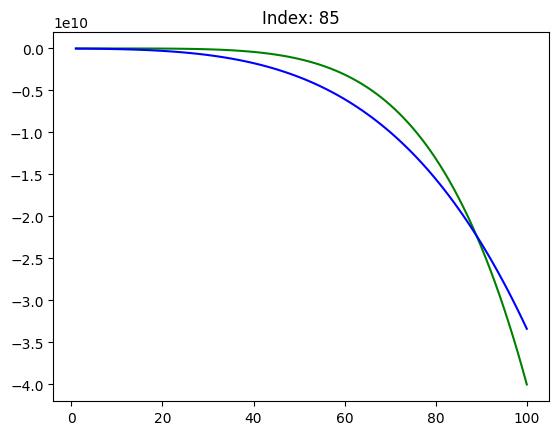

Target:   -2*x**2 + 1*x + -3
Best solution * x * -2.00 x
Best fitness -309104.4755


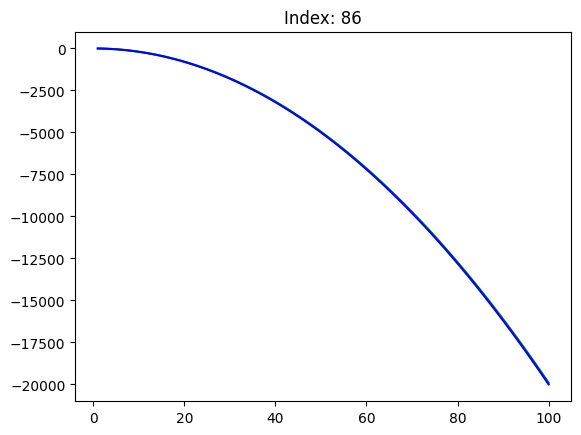

Target:   3*x**5 + 1*x**4 + 2*x + +2
Best solution + / 2.00 ^ 7.00 -9.00 + ^ * * - + 7.00 8.00 x / / 2.00 / -1.00 - * - -8.00 -4.00 / + 5.00 6.00 10.00 -1.00 -7.00 5.00 4.00 100.00
Best fitness -3.6960080214391117e+18


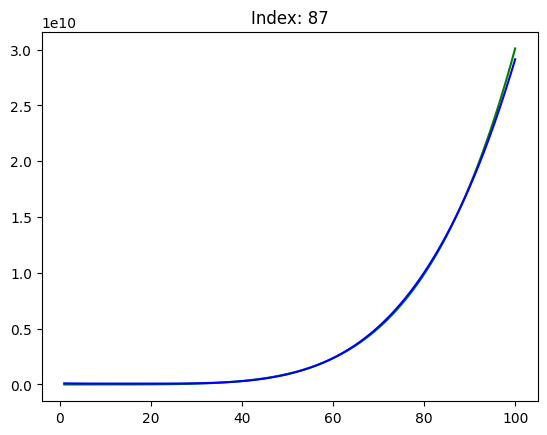

Target:   -3*x + -4
Best solution * / 6.00 / 8.00 -4.00 x
Best fitness -1601.1207


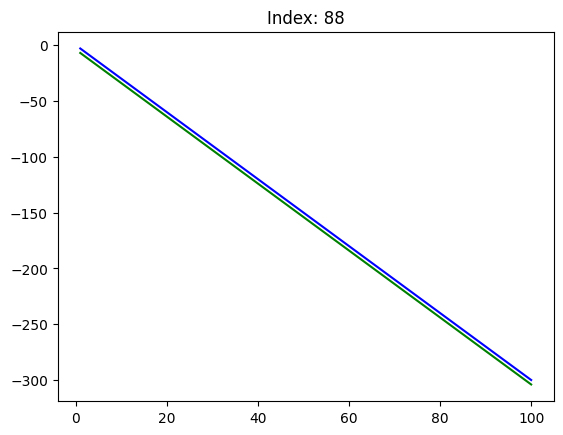

Target:   -1*x**3 + -2*x + -1
Best solution - / - * + -9.00 ^ -2.00 -1.00 - -6.00 * ^ -6.00 + 3.00 -4.00 ^ -3.00 5.00 2.00 -4.00 + ^ x 3.00 -8.00
Best fitness -334200.30437968747


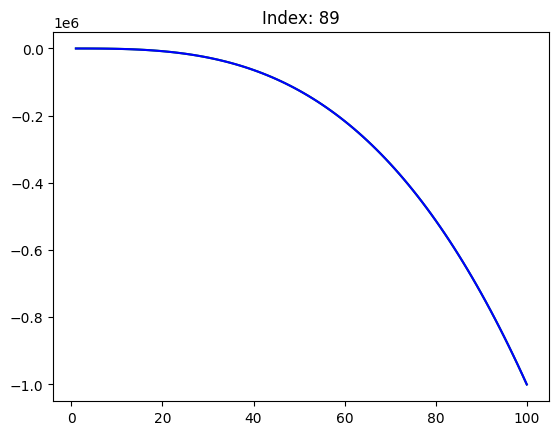

Target:   1*x**4 + 1*x**3 + -1*x + -4
Best solution ^ x 4.00
Best fitness -14790845735683.822


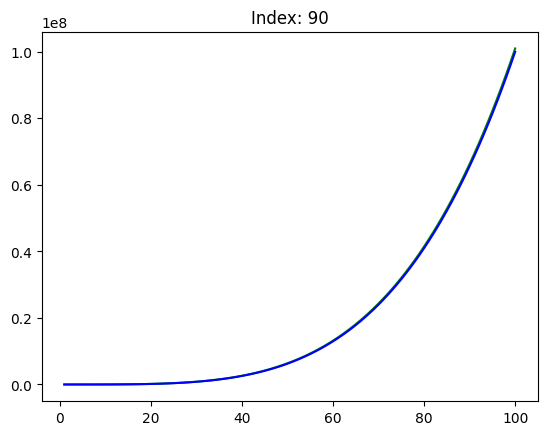

Target:   -4*x**3 + 2*x + -4
Best solution / * * -9.00 * + 29.00 ^ -4.00 4.00 - - ^ ^ 10.00 x / 2.00 x -57.00 * 2.00 * x * 3.00 1.00 x + * - / + 3.00 -5.00 -2.00 7.00 8.00 17.00
Best fitness -1268669131865.531


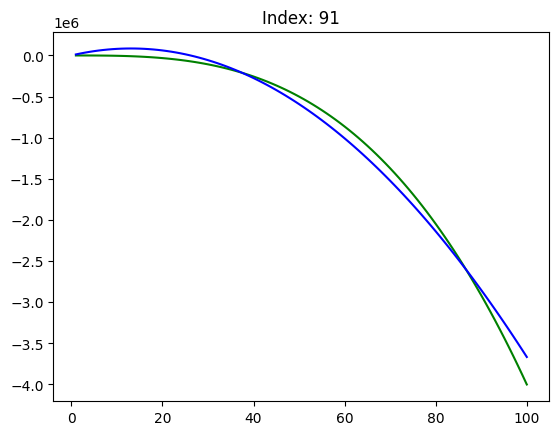

Target:   4*x**5 + 2*x**3 + -3*x**2 + 1*x + +3
Best solution - / ^ ^ - / x -9.00 / 1.00 + 11.00 + ^ 1.00 4.00 -7.00 -5.00 -2.00 / - 1.00 3.00 -3.00 * 50.00 -50.00
Best fitness -1.421187735728626e+21


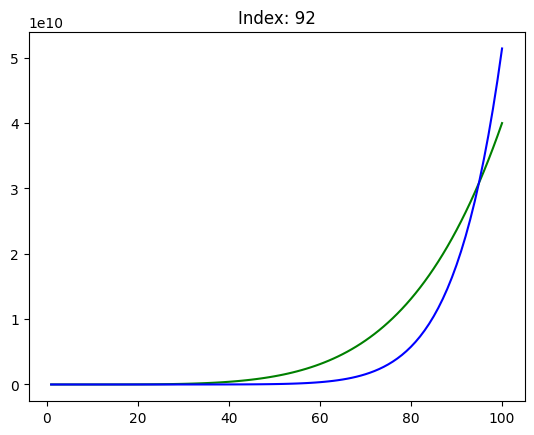

Target:   4*x**5 + -1*x**4 + 1*x**3 + 4*x**2 + 3*x + -5
Best solution * - 8.00 4.00 ^ x 5.00
Best fitness -1.135529123145082e+17


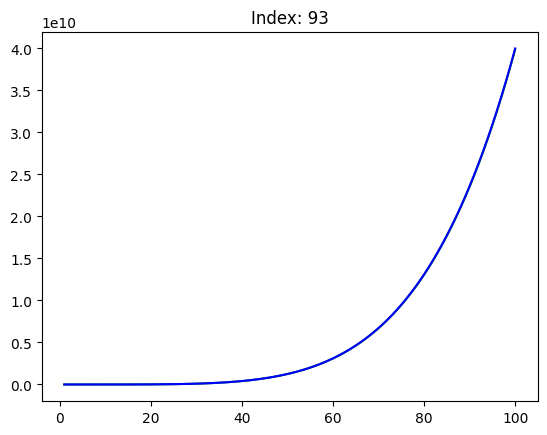

Target:   4*x**5 + 2*x**2 + -1*x + -3
Best solution / - * ^ x 5.00 * * - -6.00 -8.00 * -2.00 + 6.00 / -10.00 -6.00 -8.00 * -38.00 * 38.00 + -19.00 -20.00 / * -5.00 * - 3.00 -8.00 -10.00 9.00
Best fitness -2.0372211048016323e+17


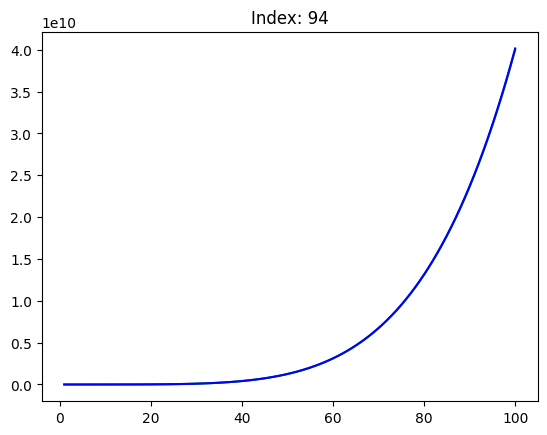

Target:   1*x**5 + -2*x**3 + -1*x + -5
Best solution ^ x 5.00
Best fitness -59189319721345.26


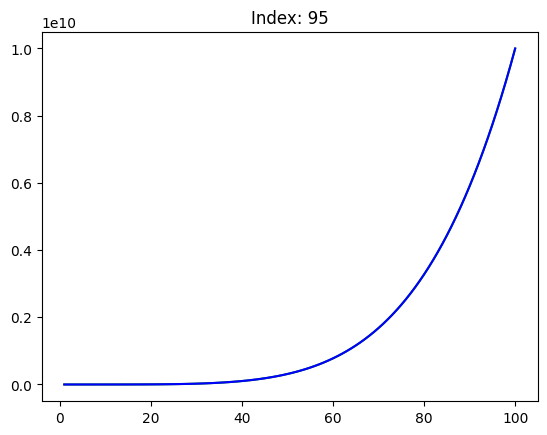

Target:   3*x**5 + 2*x**4 + 1*x + -2
Best solution ^ + 0.00 - 4.00 / + 5.00 * x -5.00 ^ 1.00 / x * ^ x 1.00 -7.00 + / - -11.00 ^ 21.00 ^ - - ^ 4.00 2.00 10.00 4.00 -6.00 x 4.00
Best fitness -5.137592113507047e+18


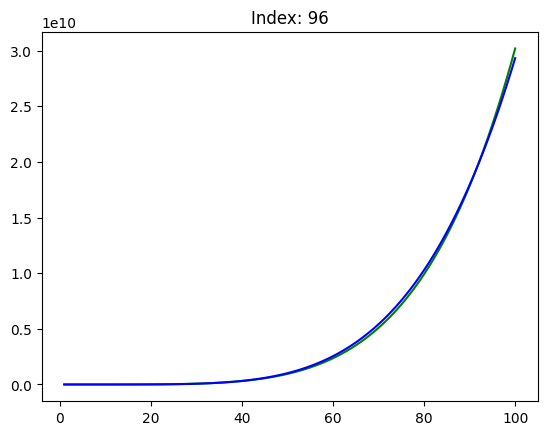

Target:   -4*x**5 + -1*x + -5
Best solution * * * x * 11.00 3.00 -8.00 - * + ^ -2.00 9.00 * x * x * + 4.00 -6.00 -7.00 11.00 - - ^ -7.00 3.00 / * * -5.00 - -1.00 3.00 ^ 3.00 - 3.00 -9.00 * -8.00 5.00 x
Best fitness -2.9097592476448106e+20


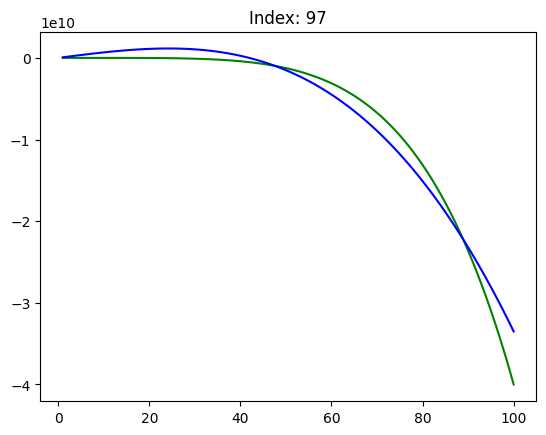

Target:   4*x + +1
Best solution - * x 5.00 + -1.00 x
Best fitness -0.0007


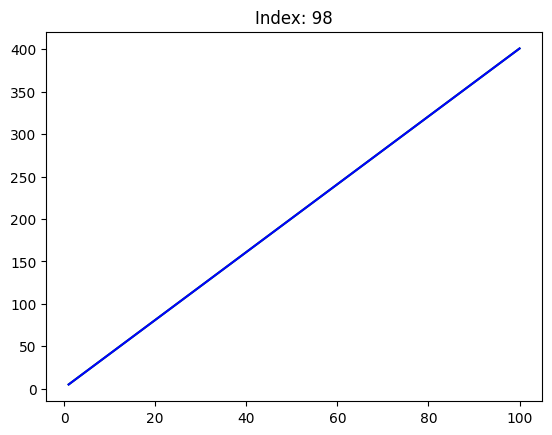

Target:   -4*x**5 + 3*x**4 + -4*x**2 + -2*x + 5
Best solution / ^ - -1.00 x 5.00 * / ^ / - 1.00 -10.00 -10.00 * 2.00 -8.00 -4.00 -5.00
Best fitness -7.609520208072782e+18


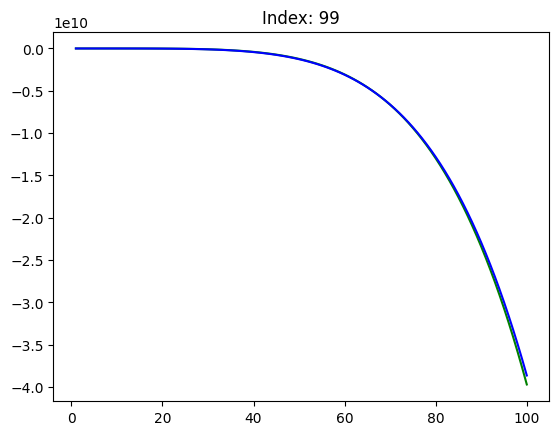

In [57]:
# indices = range(101)
indices = range(1, 101)

graph_predictions(best_models_filename='best_models.pkl', dataset_filename='dataset.csv', indices=indices)

## Extended mathematical operations 

Target:  name
Best solution -1.00
Best fitness -0.0001


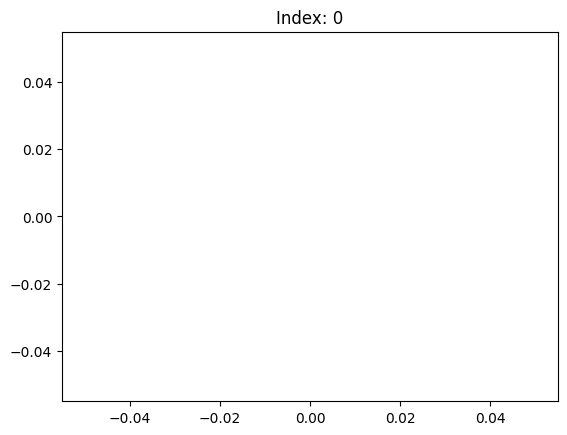

Target:  sin x
Best solution sin x
Best fitness -0.0002


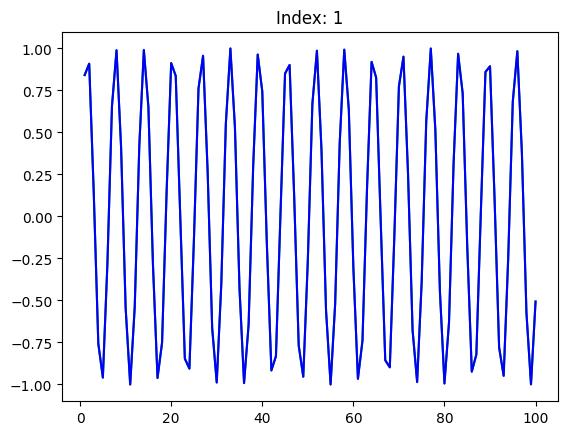

Target:  cos x
Best solution cos x
Best fitness -0.0002


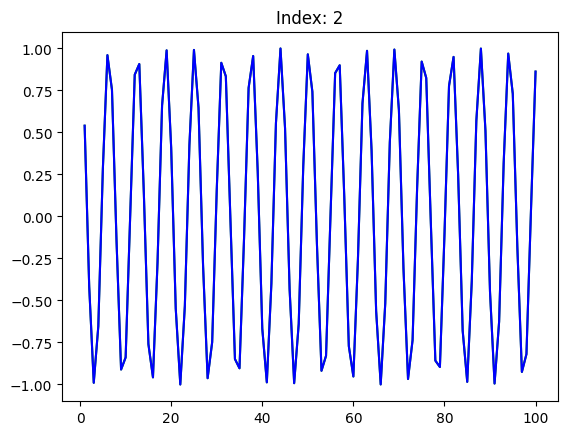

Target:  exp x
Best solution exp x
Best fitness -0.0002


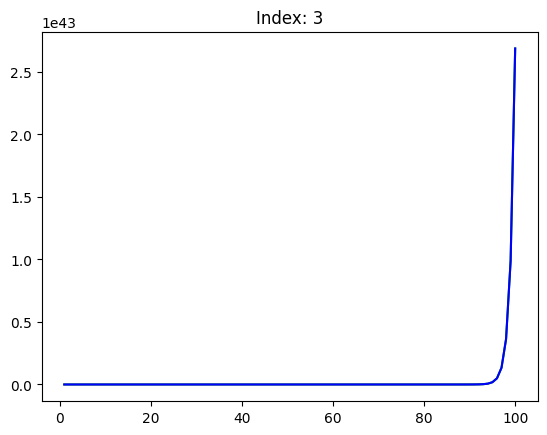

Target:  log x
Best solution log x
Best fitness -0.0002


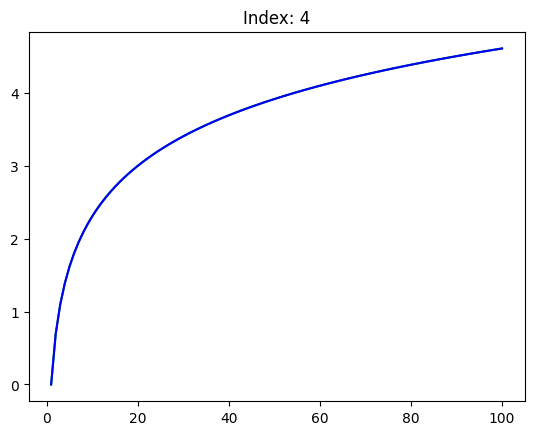

In [ ]:
# indices = range(101)
indices = [1, 2, 3, 4, 5, 6]

graph_predictions(best_models_filename='best_models_custom.pkl', dataset_filename='custom_dataset.csv', indices=indices)

## Genetic algorithm configurations

In [ ]:
dataset_file = "dataset.csv"
best_models_file = "best_models.pkl"

equation_indices = [93]
skip_indices = []

train_params = {
    'mutation_probability': 1, 
    'keep_elitism': 10,
    'num_generations': 100
}

processing 99
processing 99
processing 99


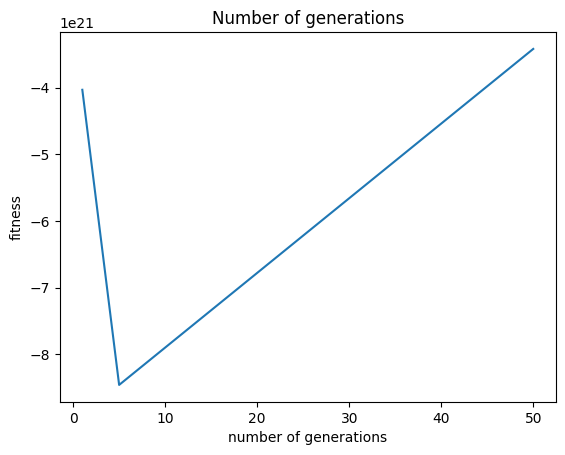

In [ ]:
num_gen = [1, 5, 50]
fitness_for_n = []

for n in num_gen:
    train_params['num_generations'] = n
    res = train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    fitness_for_n.append(res[0][1])

plt.title("Number of generations")
plt.xlabel('number of generations')
plt.ylabel('fitness')
plt.plot(num_gen, fitness_for_n)

processing 99
processing 99
processing 99


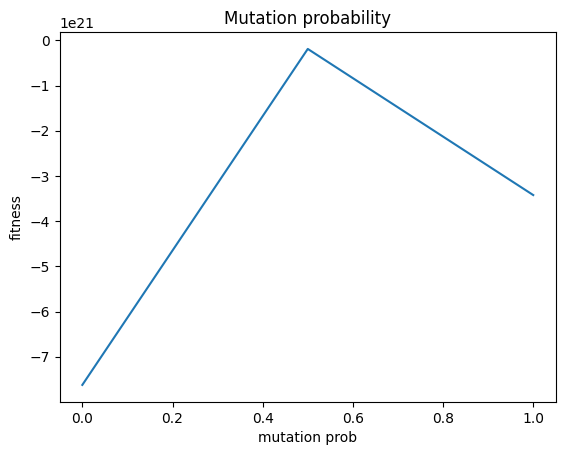

In [ ]:
mutation_probabilities = [0, 0.5, 1]
fitness_for_n = []

for m in mutation_probabilities:
    train_params['mutation_probability'] = m
    res = train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    fitness_for_n.append(res[0][1])

plt.title("Mutation probability")
plt.xlabel('mutation prob')
plt.ylabel('fitness')
plt.plot(mutation_probabilities, fitness_for_n)

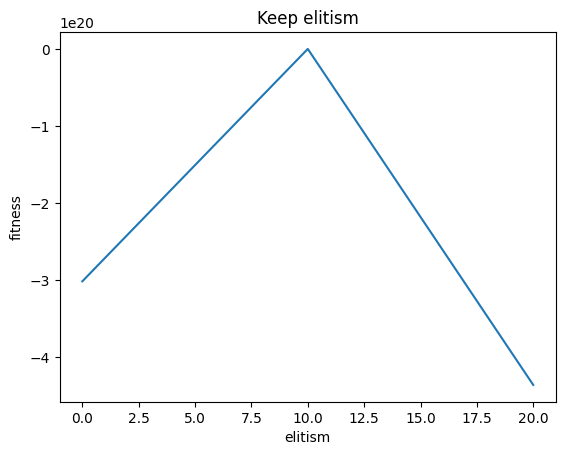

In [ ]:
keep_elitism = [0, 10, 20]
fitness_for_n = []

for e in keep_elitism:
    train_params['keep_elitism'] = e
    res = train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    fitness_for_n.append(res[0][1])

plt.title("Keep elitism")
plt.xlabel('elitism')
plt.ylabel('fitness')
plt.plot(keep_elitism, fitness_for_n)

## Time complexity

In [ ]:
dataset_file = "dataset.csv"
best_models_file = "best_models.pkl"

equation_indices = []
skip_indices = []

train_params = {
    'mutation_probability': 1, 
    'keep_elitism': 10,
    'num_generations': 100
}

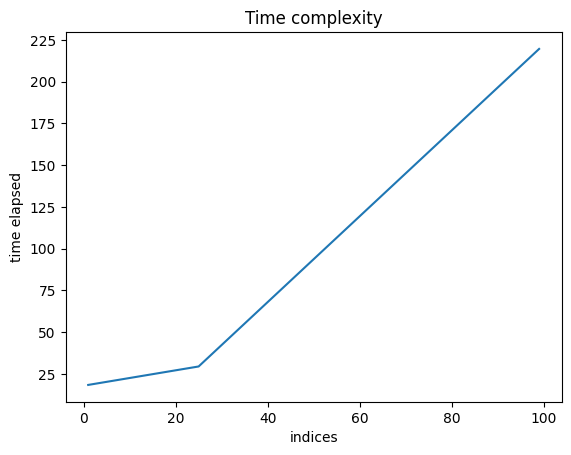

In [ ]:
indices = [1, 25, 99]
time_elapsed = []

for i in indices:
    equation_indices = [i]
    skip_indices = []
    start = time.time()
    train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    end = time.time()
    time_elapsed.append(end - start)

plt.title("Time complexity")
plt.xlabel('indices')
plt.ylabel('time elapsed')
plt.plot(indices, time_elapsed)